In [1]:
import psutil
import sys
from pathlib import Path

In [2]:
# Check if running in Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
		# Install required packages
    !pip install -q pandas numpy matplotlib seaborn sklearn xgboost
    
    # Download required files from GCS
    project = 'fwi-water-quality-sensing'
    bucket_name = 'fwi-predict'
    local_predict_df_path = '/tmp/predict_df.csv'
    local_sentinel_path = '/tmp/sentinel2.csv'
    
    !gcloud config set project {project}
    !gsutil cp gs://{bucket_name}/train/predict_dfs/jun_21_dec_24_w_metadata_predict_df.csv {local_predict_df_path}
    !gsutil cp gs://{bucket_name}/train/sentinel2/jun_21_dec_24_w_metadata.csv {local_sentinel_path}
else:
    data_dir = Path('../../data')
    local_predict_df_path = data_dir / "predict_dfs/train/jun_21_dec_24_w_metadata_predict_df.csv"
    local_sentinel_path = data_dir / "gcs/train/sentinel2/jun_21_dec_24_w_metadata.csv"


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
# Load and merge
predict_df = pd.read_csv(local_predict_df_path, parse_dates=['sample_dt'], index_col=0)
sentinel_features = pd.read_csv(local_sentinel_path).drop(columns=['system:index', '.geo'])
predict_df = predict_df.merge(sentinel_features, on='sample_idx')

# Drop unhelpful features
num_sum_cols = predict_df.columns[predict_df.columns.str.contains('num_sum')].tolist()
drop_cols = ['sample_idx', 'geometry', 'sample_dt', 'prev_sample_dt'] + num_sum_cols
predict_df = predict_df.drop(columns=drop_cols)

# Get parameters for classification problem
# predict_df['month'] = predict_df['sample_dt'].dt.month # Not including for now since last year had odd trend I don't want attributed to month

predict_df = predict_df.drop(columns=['ammonia_mg_per_L', 'ph', 'turbidity_cm', 'month'])
winkler_df = predict_df[predict_df['do_winkler']].copy()       

### Check correlations with detrending

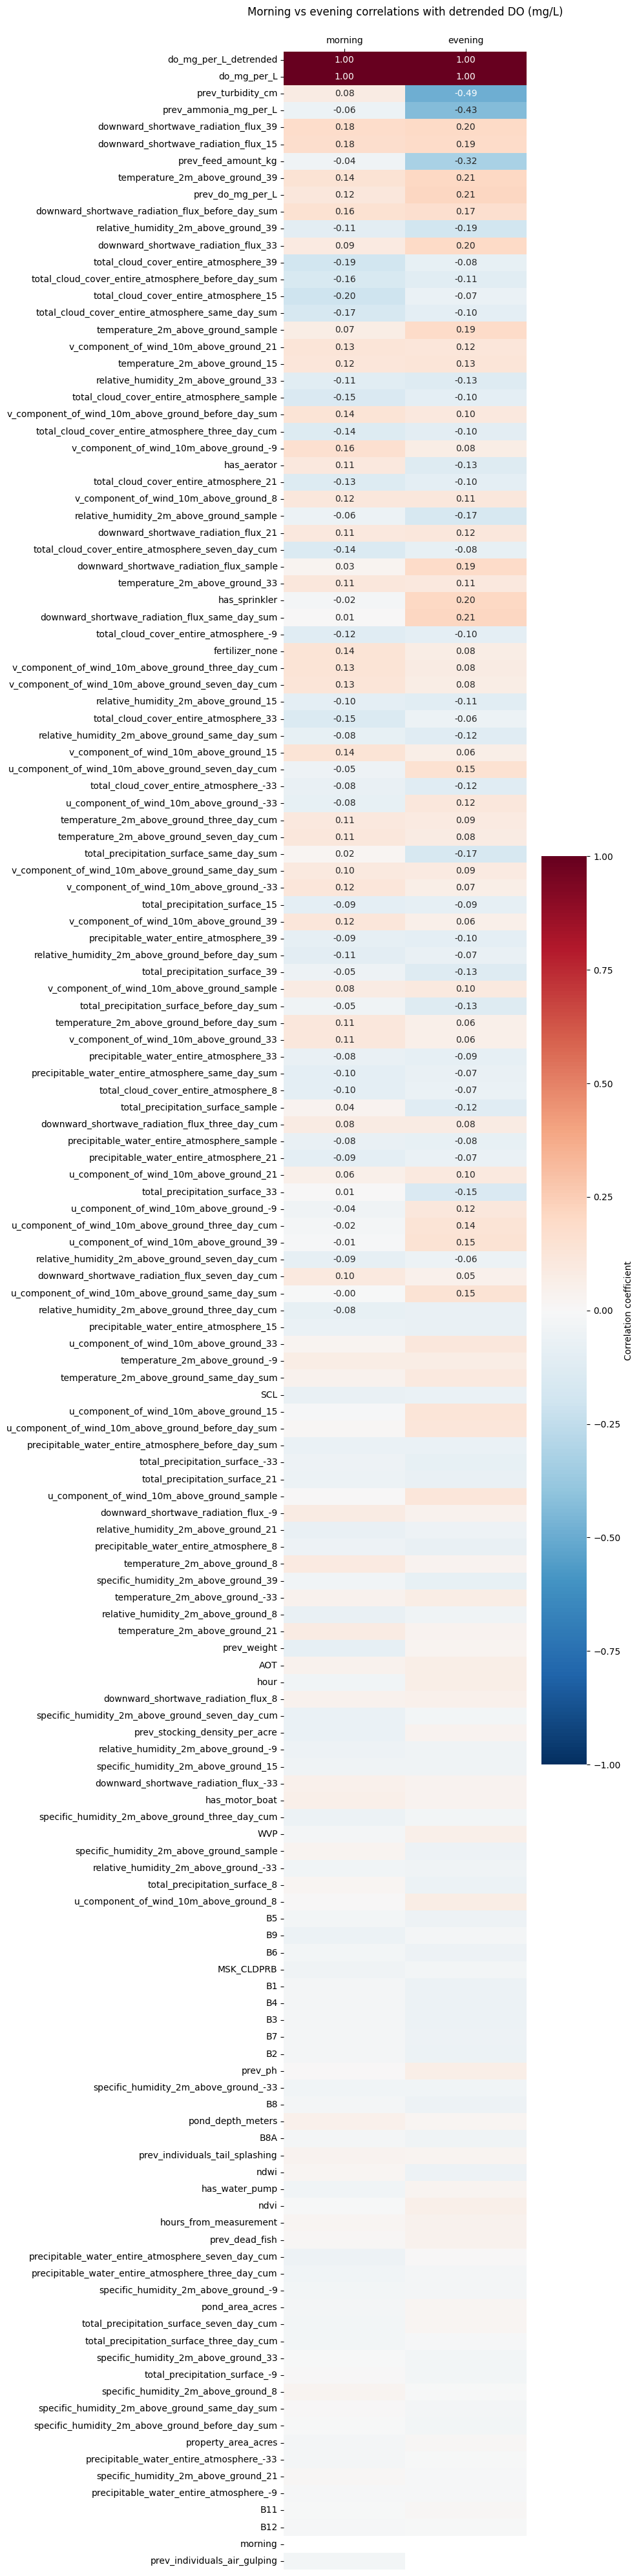

In [5]:
# Create copy of winkler_df and group by morning to detrend DO values
winkler_df = winkler_df.copy()
diurnal_means = winkler_df.groupby(['morning'])['do_mg_per_L'].transform('mean')
winkler_df['do_mg_per_L_detrended'] = winkler_df['do_mg_per_L'] - diurnal_means

# Calculate correlations separately for morning and evening
numeric_cols = winkler_df.select_dtypes(include=['float64', 'int64', 'bool']).columns.drop(['do_winkler'])

morning_corr = winkler_df[winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']
evening_corr = winkler_df[~winkler_df['morning']][numeric_cols].corr()['do_mg_per_L_detrended']

# Combine correlations into a DataFrame
corr_comparison = pd.DataFrame({
    'morning': morning_corr,
    'evening': evening_corr
})
corr_comparison['total'] = corr_comparison['morning'].abs() + corr_comparison['evening'].abs()
corr_comparison = corr_comparison.sort_values('total', ascending=False).drop('total', axis=1)

# Create heatmap
plt.figure(figsize=(10, 40))
sns.heatmap(corr_comparison,
            vmin=-1,
            vmax=1,
            cmap='RdBu_r',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Correlation coefficient'})
plt.title('Morning vs evening correlations with detrended DO (mg/L)', pad=40)
plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')
plt.tight_layout()
plt.show()

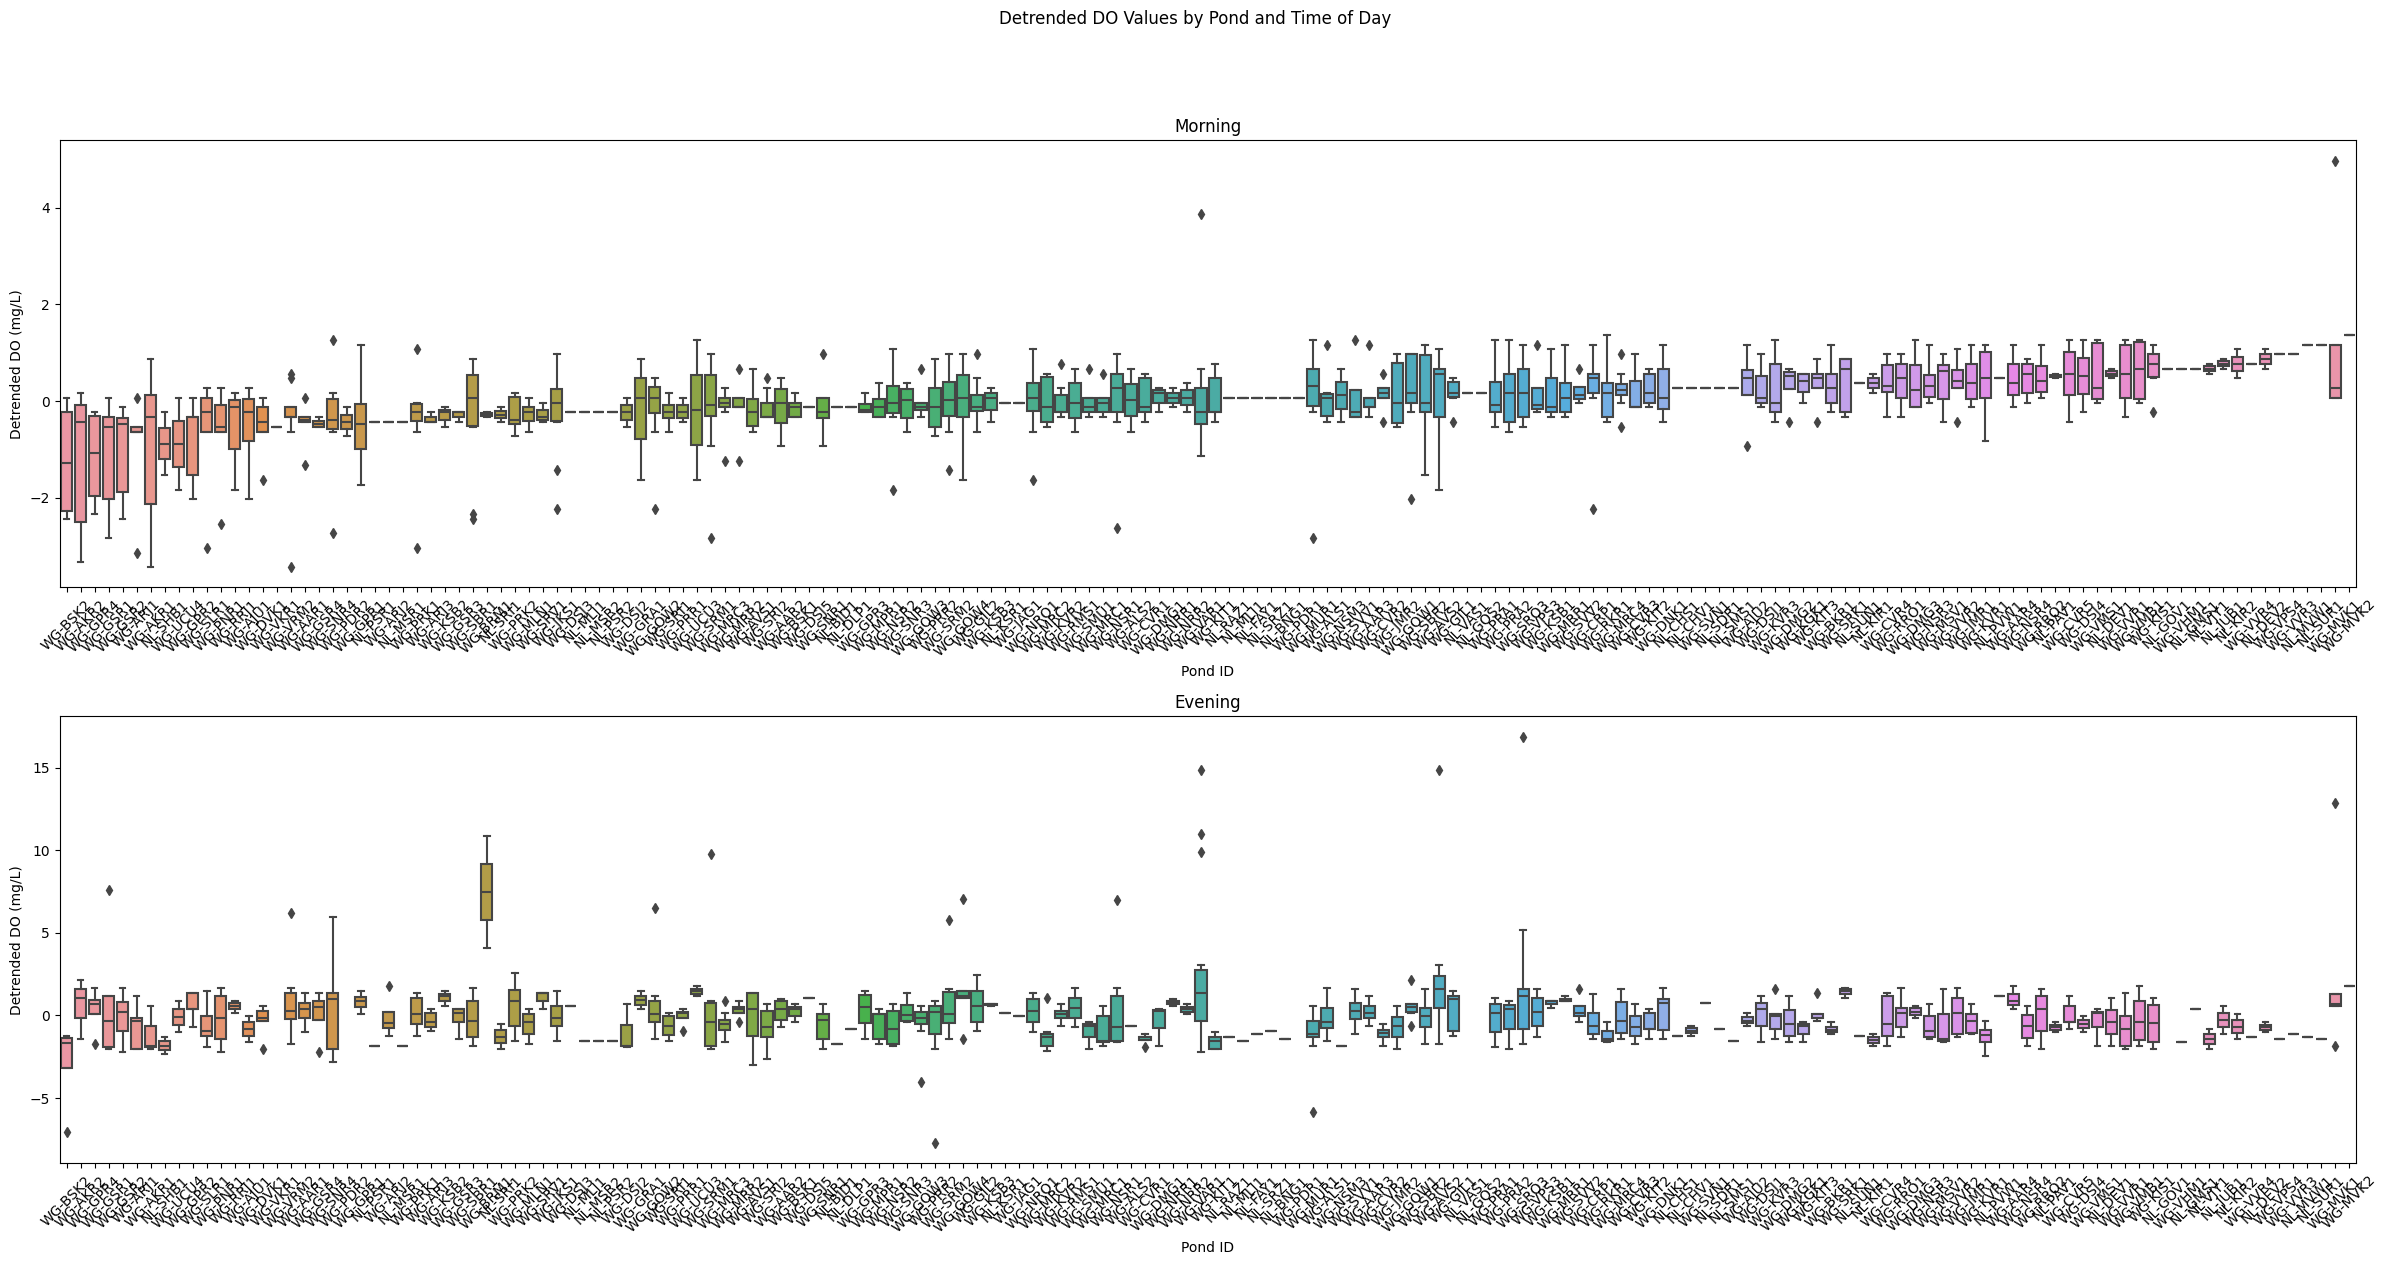

In [6]:
# Calculate morning means to sort ponds
morning_means = winkler_df[winkler_df['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df[winkler_df['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df[~winkler_df['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day', y=1.05)
plt.tight_layout()
plt.show()

WG ponds definitely have lower water quality

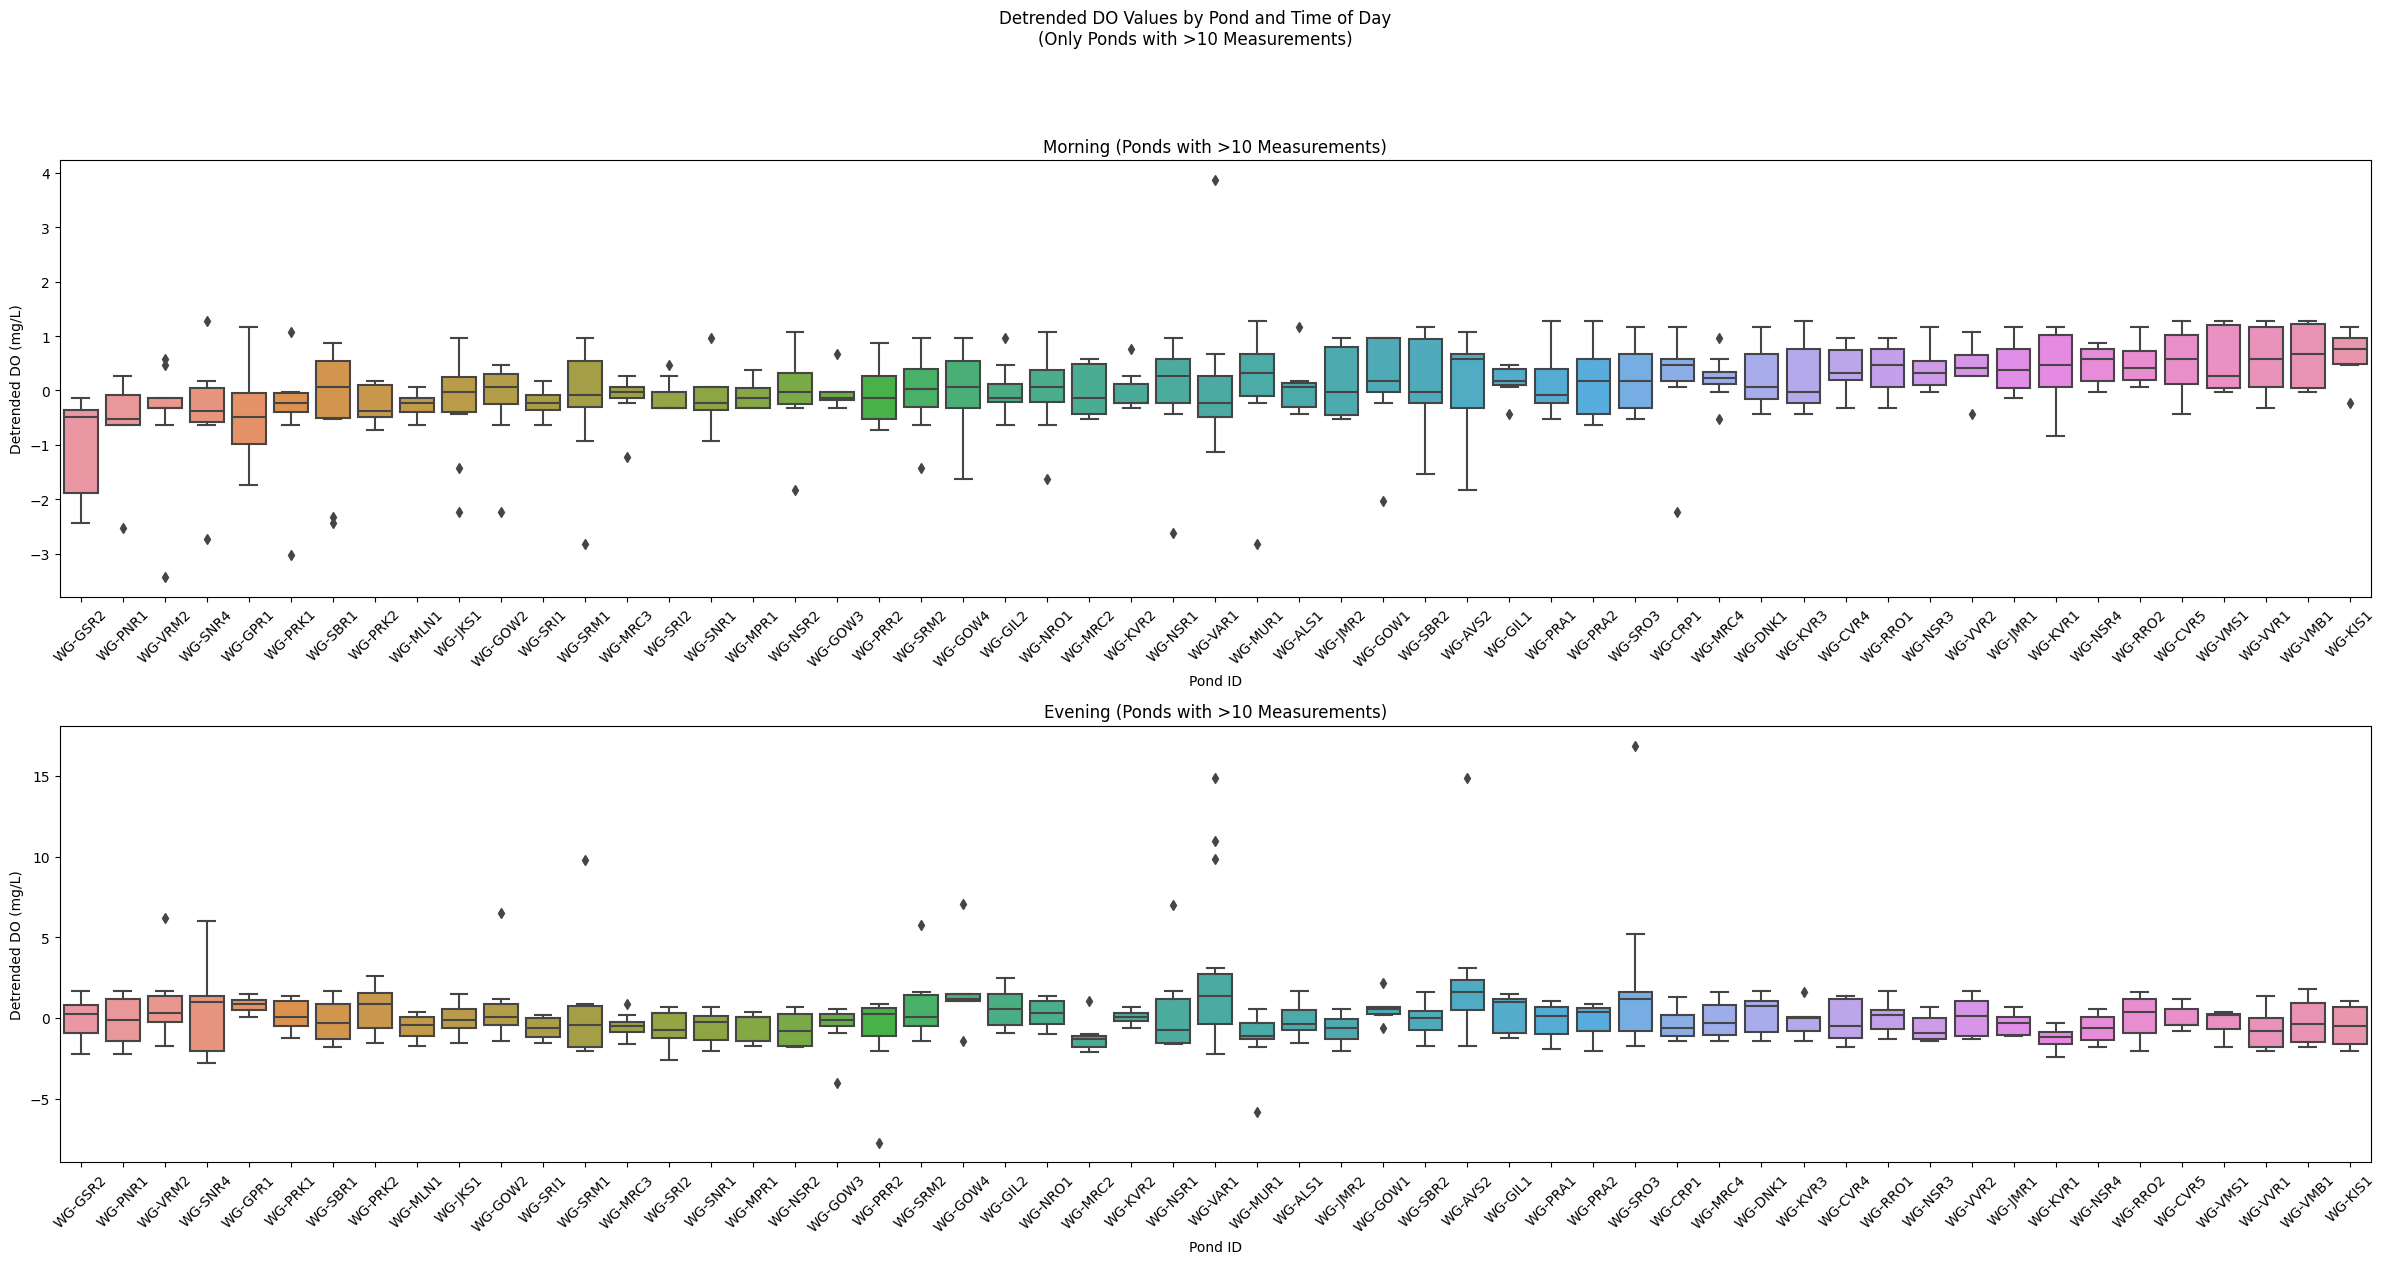

In [7]:
# Get ponds with more than 10 measurements
pond_counts = winkler_df.groupby('pond_id').size()
valid_ponds = pond_counts[pond_counts > 10].index

# Filter data for valid ponds
winkler_df_filtered = winkler_df[winkler_df['pond_id'].isin(valid_ponds)]

# Calculate morning means to sort ponds
morning_means = winkler_df_filtered[winkler_df_filtered['morning']].groupby('pond_id')['do_mg_per_L_detrended'].mean()
pond_order = morning_means.sort_values().index

# Create separate plots for morning and evening
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 12))

# Morning plot
morning_data = winkler_df_filtered[winkler_df_filtered['morning']]
sns.boxplot(data=morning_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax1)
ax1.set_title('Morning (Ponds with >10 Measurements)')
ax1.set_xlabel('Pond ID')
ax1.set_ylabel('Detrended DO (mg/L)')
ax1.tick_params(axis='x', rotation=45)

# Evening plot  
evening_data = winkler_df_filtered[~winkler_df_filtered['morning']]
sns.boxplot(data=evening_data, x='pond_id',
            y='do_mg_per_L_detrended', order=pond_order, ax=ax2)
ax2.set_title('Evening (Ponds with >10 Measurements)')
ax2.set_xlabel('Pond ID')
ax2.set_ylabel('Detrended DO (mg/L)')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Detrended DO Values by Pond and Time of Day\n(Only Ponds with >10 Measurements)', y=1.05)
plt.tight_layout()
plt.show()

Categoricals to deal with:
- farm
- region
- month
- pond_id
- village
- SCL

In [8]:
categoricals = ['farm', 'region', 'month', 'pond_id', 'village', 'SCL', 'morning']
non_categoricals = winkler_df.columns[~winkler_df.columns.isin(categoricals)].tolist()

In [9]:
# Calculate correlations separately for morning and evening
morning_data = winkler_df[winkler_df['morning']]
evening_data = winkler_df[~winkler_df['morning']]

# Calculate correlations for morning data
morning_corr = morning_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
morning_high_corr = morning_corr[morning_corr > 0.17].index.tolist()

# Calculate correlations for evening data  
evening_corr = evening_data[non_categoricals].corr()['do_mg_per_L_detrended'].abs()
evening_high_corr = evening_corr[evening_corr > 0.17].index.tolist()

# Combine features that are important for either morning or evening
high_corr_features = list(set(morning_high_corr + evening_high_corr))

# Remove target variables from features list
high_corr_features = [col for col in high_corr_features if col not in ['do_mg_per_L', 'do_mg_per_L_detrended']]

print("Number of high correlation features:", len(high_corr_features))


Number of high correlation features: 16


In [10]:
winkler_df.columns.tolist()

['pond_id',
 'region',
 'farm',
 'morning',
 'hour',
 'do_mg_per_L',
 'do_winkler',
 'prev_matches_time',
 'prev_do_mg_per_L',
 'prev_ph',
 'prev_turbidity_cm',
 'prev_ammonia_mg_per_L',
 'prev_individuals_air_gulping',
 'prev_individuals_tail_splashing',
 'prev_dead_fish',
 'prev_feed_amount_kg',
 'prev_stocking_density_per_acre',
 'prev_weight',
 'prev_species_catla',
 'prev_species_rohu',
 'prev_species_roopchand',
 'prev_species_grass_carp',
 'prev_species_pangasius',
 'prev_species_whiteleg_shrimp',
 'property_area_acres',
 'pond_area_acres',
 'pond_depth_meters',
 'has_water_pump',
 'has_aerator',
 'has_motor_boat',
 'has_sprinkler',
 'pond_preparation',
 'village',
 'fertilizer_manure',
 'fertilizer_dap',
 'fertilizer_potash',
 'fertilizer_urea',
 'fertilizer_phosphate',
 'fertilizer_amm_sulph',
 'fertilizer_probiotics',
 'fertilizer_magnesium',
 'fertilizer_gromor',
 'fertilizer_lime',
 'fertilizer_none',
 'feed_mash',
 'feed_pellets_float',
 'feed_pellets_sink',
 'feed_dorb',


In [11]:
experiment_df = winkler_df.drop(columns=['do_mg_per_L_detrended']).copy()

In [12]:
# Feature categories
base_weather_forecast_features = experiment_df.columns[experiment_df.columns.str.contains('downward_shortwave|precipitable|relative_hum|specific_hum|temperature_2m|total_cloud|total_precip')].tolist()
ext_weather_forecast_features = base_weather_forecast_features + experiment_df.columns[experiment_df.columns.str.contains('u_component|v_component')].tolist()
satellite_features = ['AOT', 'B1', 'B11', 'B12', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'MSK_CLDPRB', 'SCL', 'WVP', 'hours_from_measurement', 'ndvi','ndwi']
lag_features = experiment_df.columns[experiment_df.columns.str.startswith('prev_')].tolist()
pond_features = (
  experiment_df.columns[experiment_df.columns.str.startswith('fertilizer_|feed_|has_')].tolist() + ['pond_area_acres', 'property_area_acres', 'pond_depth_meters', 'pond_preparation']
)

# Feature sets
base_feature_set = ['morning', 'region', 'hour'] + base_weather_forecast_features
ext_weather_forecast_set = base_feature_set + ext_weather_forecast_features

# Add categoricals
base_w_categoricals = list(set(base_feature_set + categoricals))
base_w_lag_features = base_feature_set + lag_features
base_w_satellite_features = base_feature_set + satellite_features
base_w_pond_features = base_feature_set + pond_features
high_corr_set = high_corr_features + ['morning', 'region']

In [13]:
base_w_satellite_features

['morning',
 'region',
 'hour',
 'downward_shortwave_radiation_flux_-33',
 'downward_shortwave_radiation_flux_-9',
 'downward_shortwave_radiation_flux_15',
 'downward_shortwave_radiation_flux_21',
 'downward_shortwave_radiation_flux_33',
 'downward_shortwave_radiation_flux_39',
 'downward_shortwave_radiation_flux_8',
 'downward_shortwave_radiation_flux_before_day_sum',
 'downward_shortwave_radiation_flux_same_day_sum',
 'downward_shortwave_radiation_flux_sample',
 'downward_shortwave_radiation_flux_seven_day_cum',
 'downward_shortwave_radiation_flux_three_day_cum',
 'precipitable_water_entire_atmosphere_-33',
 'precipitable_water_entire_atmosphere_-9',
 'precipitable_water_entire_atmosphere_15',
 'precipitable_water_entire_atmosphere_21',
 'precipitable_water_entire_atmosphere_33',
 'precipitable_water_entire_atmosphere_39',
 'precipitable_water_entire_atmosphere_8',
 'precipitable_water_entire_atmosphere_before_day_sum',
 'precipitable_water_entire_atmosphere_same_day_sum',
 'precipit

In [14]:
if IN_COLAB:
		# Make sure reflects latest versions in local repository
		WQ_RANGES = {
				'do_mg_per_L': {
						'required': {
								'morning': (3, 5),
								'evening': (8, 12)
						},
						'ideal': {
								'morning': (4, 5),
								'evening': (8, 10)
						}
				},
				'ph': {
						'required': (6.5, 8.5),
						'ideal': (7, 8)
				},
				'ammonia_mg_per_L': {
						'required': (0, 0.5),
						'ideal': (0, 0.15)
				},
				'turbidity_cm': {
						'required': (20, 50),
						'ideal': (30, 40)
				}
		}
  
		def get_in_required_range(parameter: str, values, periods=None):
				"""Checks if water quality parameter is below, within, or above the required range.

				Parameters:
						parameter (str): The water quality parameter to check (e.g., 'do', 'ph', 'ammonia', 'turbidity').
						values: Array-like of measurement values (numpy array or pandas Series).
						periods: Array-like of periods ('morning', 'evening', etc.), required for period-dependent parameters.

				Returns:
						Array-like: Array of strings indicating if values are 'below', 'within', or 'above' the required range.
				"""
				# Convert inputs to numpy arrays for consistent handling
				values = np.asarray(values)
				
				# Ensure the parameter is valid
				if parameter not in WQ_RANGES:
						raise ValueError(f"Invalid parameter: {parameter}. Must be one of {list(WQ_RANGES.keys())}.")
				
				required_ranges = WQ_RANGES[parameter]['required']
				
				# Handle case where ranges are split by periods
				if isinstance(required_ranges, dict):
						if periods is None:
								raise ValueError(f"Periods must be provided for parameter {parameter}")
								
						periods = np.asarray(periods)
						result = np.full(values.shape, '', dtype='U6') # Initialize output array

						# Process each period
						for period, (low, high) in required_ranges.items():
								mask = periods == period
								conditions = [values[mask] < low, (values[mask] >= low) & (values[mask] <= high), values[mask] > high]
								result[mask] = np.select(conditions, ['below', 'within', 'above'], default='')
								
						return result
				
				# Handle case where ranges are not split by periods
				low, high = required_ranges
				conditions = [values < low, (values >= low) & (values <= high), values > high]
				return np.select(conditions, ['below', 'within', 'above'], default='')
		
else:
		from fwi_predict.constants import WQ_RANGES
		from fwi_predict.wq import get_in_required_range

In [15]:
# Import necessary libraries
import pickle
from typing import List, Dict, Tuple

import shap
import yaml
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import root_mean_squared_error, precision_score, recall_score, r2_score
from sklearn.model_selection import cross_val_predict, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder
from xgboost import XGBRFRegressor, XGBRegressor

In [16]:
# Define diurnal detrend transform
class DiurnalDetrend(BaseEstimator, TransformerMixin):
    """Detrend data by subtracting morning/evening means."""
    def fit(self, X, y=None):
        # Store feature names from X
        self.feature_names_in_ = np.asarray(X.columns.tolist())
        
        # Calculate means for morning/evening
        df = pd.DataFrame({'y': y, 'morning': X['morning']})
        self.morning_mean_ = df[df['morning']]['y'].mean()
        self.evening_mean_ = df[~df['morning']]['y'].mean()
        return self

    def transform(self, X, y=None):
        if y is not None:
            y_detrended = y.copy()
            y_detrended[X['morning']] -= self.morning_mean_
            y_detrended[~X['morning']] -= self.evening_mean_
            return y_detrended
        return X
    
    def inverse_transform(self, X, y):
        y_retrended = y.copy()
        y_retrended[X['morning']] += self.morning_mean_
        y_retrended[~X['morning']] += self.evening_mean_
        return y_retrended
    
    def get_feature_names_out(self, input_features=None):
        """Get output feature names for transformation.
        
        Parameters
        ----------
        input_features : list of str or None, default=None
            Input feature names. If None, then feature_names_in_ is used.
            
        Returns
        -------
        feature_names_out : ndarray of str
            Output feature names.
        """
        if input_features is None:
            input_features = self.feature_names_in_
        return np.asarray(input_features)

In [17]:
workers = psutil.cpu_count() if IN_COLAB else psutil.cpu_count(logical=False) - 1
print(f"Workers: {workers}")

Workers: 9


In [18]:
def evaluate_predictions(y_true, y_pred, morning_series):
    """Evaluate model performance including DO range classification."""
    # Get range classifications
    time_of_day = morning_series.apply(lambda x: 'morning' if x else 'evening')
    true_ranges = get_in_required_range('do_mg_per_L', y_true, time_of_day)
    pred_ranges = get_in_required_range('do_mg_per_L', y_pred, time_of_day)
    
    # Calculate metrics
    r2 = r2_score(y_true, y_pred)
    range_accuracy = (true_ranges == pred_ranges).mean()
    
    return {
        'r2_score': r2,
        'range_accuracy': range_accuracy,
        'y_true': y_true,
        'y_pred': y_pred,
        'true_ranges': true_ranges,
        'pred_ranges': pred_ranges
    }


def run_experiment(df: pd.DataFrame, 
                   feature_set: List[str],
                   categoricals: List[str],
                   feature_selection: bool = False,
                   diurnal_detrend: bool = True,
                   scoring: str = 'neg_root_mean_squared_error',
                   workers: int = workers) -> Dict:
    """Run modeling experiment with given feature set."""
    
    # Prepare data
    X = df[feature_set]
    y = df['do_mg_per_L']
    
    # Create preprocessing steps
    numeric_features = [col for col in feature_set if col not in categoricals]
    categorical_features = [col for col in feature_set if col in categoricals]
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numeric_features),
            ('cat', TargetEncoder(), categorical_features)
        ]
    )
    
    if feature_selection:
        # Do feature selection first, outside the main CV loop
        feature_selector = Pipeline([
            ('detrend', DiurnalDetrend() if diurnal_detrend else 'passthrough'),
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('rfecv', RFECV(
                RandomForestRegressor(random_state=42),
                cv=5,
                scoring=scoring,
                n_jobs=workers
            ))
        ])
        
        # Fit feature selector
        feature_selector.fit(X, y)
        
        # Get selected features
        # Get feature names with prefixes from RFECV
        feature_names = feature_selector.get_feature_names_out()
        selected_features = [name.replace('num__', '').replace('cat__', '') for name in feature_names]
        
        # Update X to only include selected features
        X = X[selected_features]
        
        # Update preprocessor for selected features
        numeric_features = [col for col in selected_features if col not in categoricals]
        categorical_features = [col for col in selected_features if col in categoricals]
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', 'passthrough', numeric_features),
                ('cat', TargetEncoder(), categorical_features)
            ]
        )
                
        # Create ranking vs RMSE plot
        plt.figure(figsize=(10, 6))
        rfe_results = pd.DataFrame(feature_selector.named_steps['rfecv'].cv_results_)
        plt.errorbar(rfe_results['n_features'], 
                		 rfe_results['mean_test_score'],
                     rfe_results['std_test_score'])
        plt.xlabel('Number of features selected')
        plt.ylabel('Cross-validation RMSE')
        plt.title('Feature selection: Number of features vs RMSE')
        plt.grid(True)
        plt.show()

		# Main training pipeline without feature selection
    pipeline = Pipeline([
        ('detrend', DiurnalDetrend() if diurnal_detrend else 'passthrough'),
        ('preprocessor', preprocessor),
        ('scaler', StandardScaler()),
        ('regressor', XGBRegressor(random_state=42))
    ])
    
    # Define parameter grid
    param_grid = {
        'regressor__eta': [0.03, 0.1, 0.2],
        'regressor__gamma': [0, 0.05],
        'regressor__max_depth': [3, 6, 10],
        'regressor__min_child_weight': [1, 5, 10],
        'regressor__subsample': [0.3, 0.5, 1],
        'regressor__alpha': [0, 0.2]
    }
    
    # Perform grid search
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=workers,
        verbose=1
    )
    
    # Fit model
    grid_search.fit(X, y)
    
    # Get cross-validation predictions
    best_estimator = grid_search.best_estimator_
    cv_predictions = cross_val_predict(
        best_estimator,
        X, y,
        cv=cv
    )
    
    # Evaluate performance
    results = evaluate_predictions(y, cv_predictions, df['morning'])
    
    # Plot hyperparameter effects
    cv_results = pd.DataFrame(grid_search.cv_results_)
    # Get hyperparameter columns
    param_cols = [col for col in cv_results.columns if col.startswith('param_regressor__')]
    n_params = len(param_cols)
    
    # Calculate subplot layout
    n_rows = int(np.ceil(np.sqrt(n_params)))
    n_cols = int(np.ceil(n_params / n_rows))
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(7*n_cols, 5*n_rows))
    axes = axes.flatten()
    
    # Create plots for each hyperparameter
    for i, param_col in enumerate(param_cols):
        param_name = param_col.replace('param_regressor__', '')
        sns.boxplot(data=cv_results, x=param_col, y='mean_test_score', ax=axes[i])
        axes[i].set_title(f'Effect of {param_name}')
        axes[i].set_ylabel('Mean CV Score (R²)')
        
    # Hide any empty subplots
    for i in range(n_params, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Plot cross-validation fold performance
    cv_fold_scores = []
    for fold_idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        y_true_fold = y.iloc[test_idx]
        y_pred_fold = cv_predictions[test_idx]
        
        # Calculate classification metrics using WQ ranges
        true_classes = get_in_required_range('do_mg_per_L', y_true_fold, ['morning']*len(y_true_fold))
        pred_classes = get_in_required_range('do_mg_per_L', y_pred_fold, ['morning']*len(y_pred_fold))
        
        # Calculate per-class metrics
        for class_name in ['below', 'within', 'above']:
            precision = precision_score(true_classes == class_name, pred_classes == class_name)
            recall = recall_score(true_classes == class_name, pred_classes == class_name)
            
            cv_fold_scores.append({
                'fold': fold_idx + 1,
                'class': class_name,
                'precision': precision,
                'recall': recall,
            })
    
    cv_scores_df = pd.DataFrame(cv_fold_scores)
    
    # Plot fold performance comparisons
    plt.figure(figsize=(10, 5))
    plot_data = cv_scores_df.melt(id_vars=['fold', 'class'], 
                                 value_vars=['precision', 'recall'],
                                 var_name='metric', value_name='score')
    
    sns.boxplot(data=plot_data, x='class', y='score', hue='metric')
    plt.title('Precision and recall scores by class across folds')
    plt.tight_layout()
    plt.show()
    
    # Plot predictions vs actuals
    plt.figure(figsize=(15, 5))
    
    # Morning predictions
    plt.subplot(1, 2, 1)
    morning_mask = df['morning']
    plt.scatter(results['y_true'][morning_mask], 
                results['y_pred'][morning_mask], alpha=0.5)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()], 
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][morning_mask], results['y_pred'][morning_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][morning_mask].min(), 
              results['y_true'][morning_mask].max()],
             [p(results['y_true'][morning_mask].min()), 
              p(results['y_true'][morning_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Morning: Predicted vs actual DO levels')
    
    # Evening predictions
    plt.subplot(1, 2, 2)
    evening_mask = ~df['morning']
    plt.scatter(results['y_true'][evening_mask],
                results['y_pred'][evening_mask], alpha=0.5)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             'r--', lw=2, label='Perfect prediction')
    
    # Add trend line
    z = np.polyfit(results['y_true'][evening_mask], results['y_pred'][evening_mask], 1)
    p = np.poly1d(z)
    plt.plot([results['y_true'][evening_mask].min(),
              results['y_true'][evening_mask].max()],
             [p(results['y_true'][evening_mask].min()),
              p(results['y_true'][evening_mask].max())],
             'g--', lw=2, label='Trend line')
    plt.legend()
    plt.xlabel('Actual DO (mg/L)')
    plt.ylabel('Predicted DO (mg/L)')
    plt.title('Evening: Predicted vs actual DO levels')
    
    plt.tight_layout()
    plt.show()
    
		# Calculate SHAP values
    
    # Get the random forest model and preprocessor from pipeline
    rf_model = best_estimator.named_steps['regressor']
    preprocess_pipeline = best_estimator[:-1]
    X_transformed = preprocess_pipeline.transform(X)
    feature_names = best_estimator[1].feature_names_in_ # In case diurnal detrend set to passthrough
        
    # Create SHAP explainer
    explainer = shap.TreeExplainer(rf_model, feature_names=feature_names)
    explanation = explainer(X_transformed)
    
    # Create figure with two subplots
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create beeswarm plot
    plt.sca(ax)
    shap.plots.beeswarm(
        explanation,
        max_display=15,
        group_remaining_features=True,
        show=False
    )
    plt.title('SHAP beeswarm plot: Feature impact distribution', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Store feature importance based on SHAP values
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': explanation.abs.mean(0).values
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_estimator': grid_search.best_estimator_,
        'results': results,
        'feature_names': feature_names,
        'feature_importance': feature_importance
    }


Running experiment with base features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


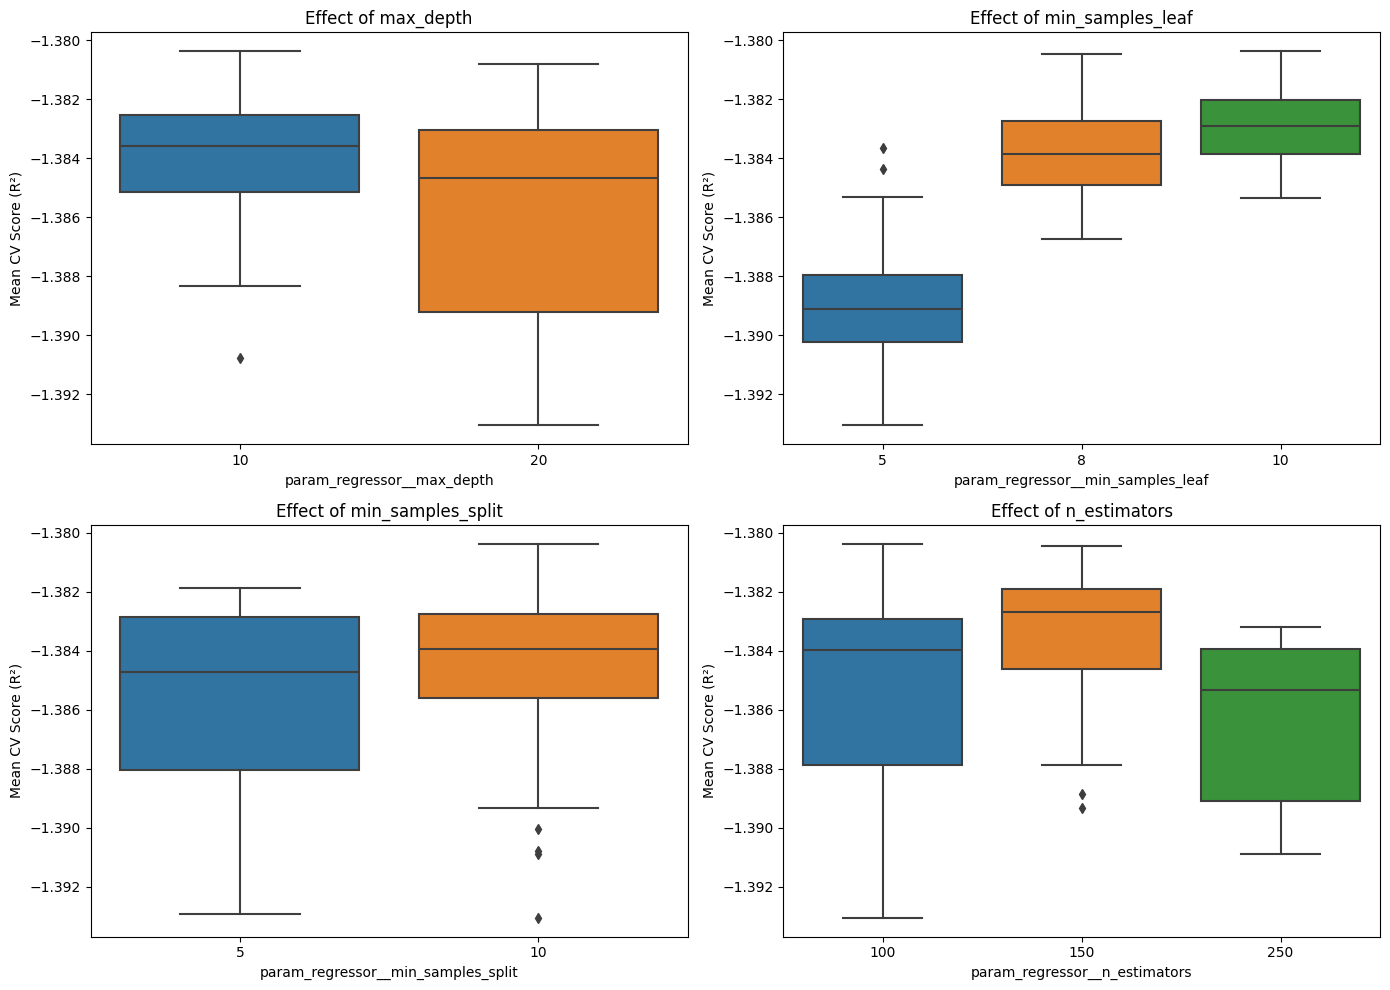

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(

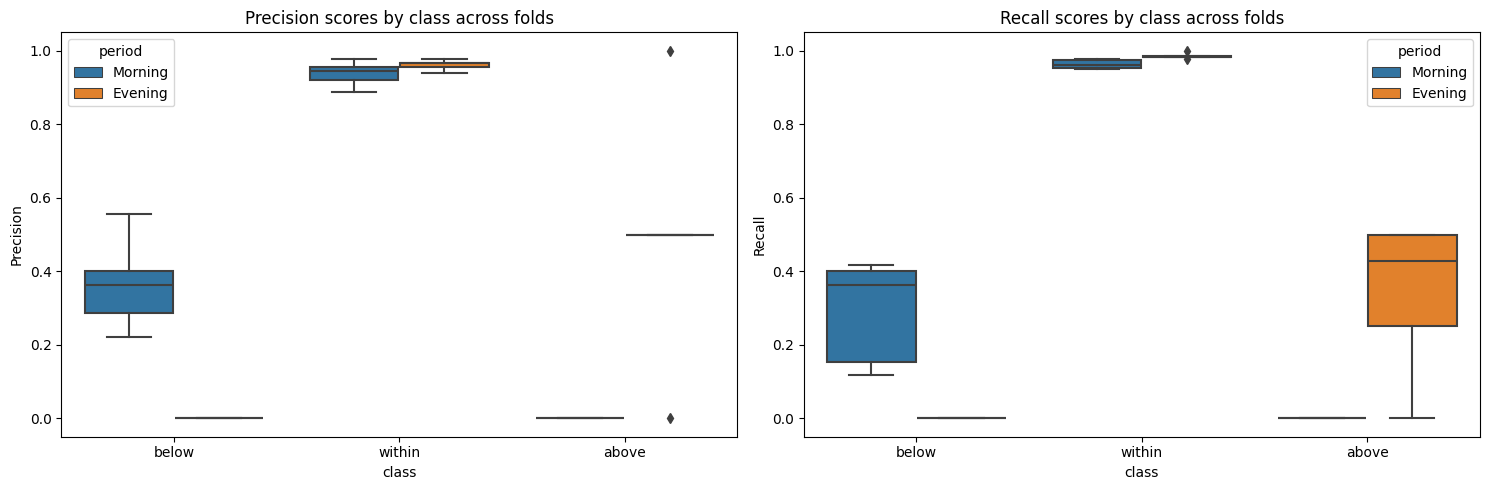

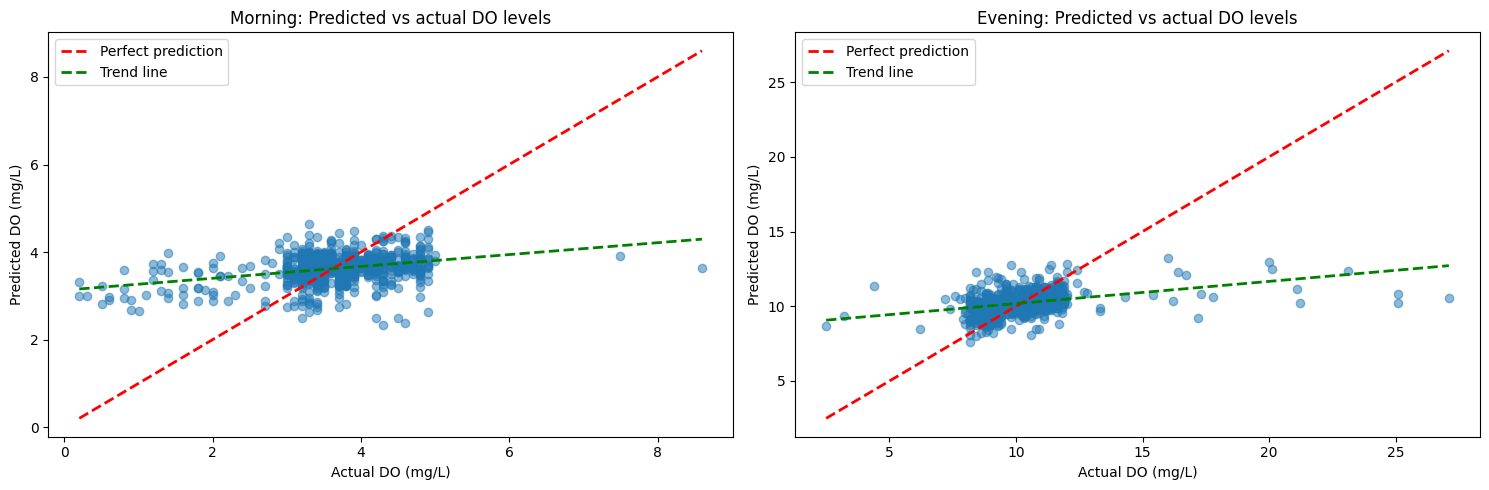

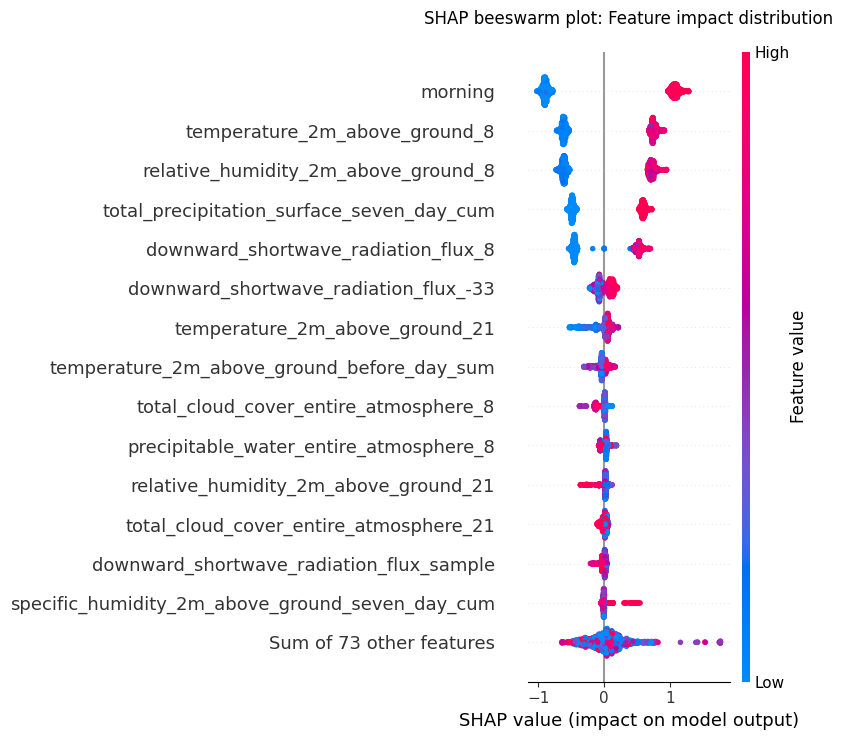

Best score: -1.380
Range prediction accuracy: 0.926

Running experiment with base_w_categoricals features...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


KeyboardInterrupt: 

In [21]:
# Run experiments with different feature sets
feature_sets = {
    'base': base_feature_set,
    'base_w_categoricals': base_w_categoricals,
    'base_lag': base_w_lag_features,
    'base_satellite': base_w_satellite_features,
    'base_pond': base_w_pond_features,
    'high_corr_set': high_corr_set
}

results = {}
for name, features in feature_sets.items():
    print(f"\nRunning experiment with {name} features...")
    results[name] = run_experiment(experiment_df, features, categoricals)
    print(f"Best score: {results[name]['best_score']:.3f}")
    print(f"Range prediction accuracy: {results[name]['results']['range_accuracy']:.3f}")



Analyzing base feature set...

Below range DO (n=67)
RMSE: 2.257 | R²: -0.588
Precision: 0.411 | Recall: 0.343

Within range DO (n=1,325)
RMSE: 0.847 | R²: 0.931
Precision: 0.954 | Recall: 0.967

Above range DO (n=25)
RMSE: 7.609 | R²: -1.401
Precision: 0.389 | Recall: 0.280


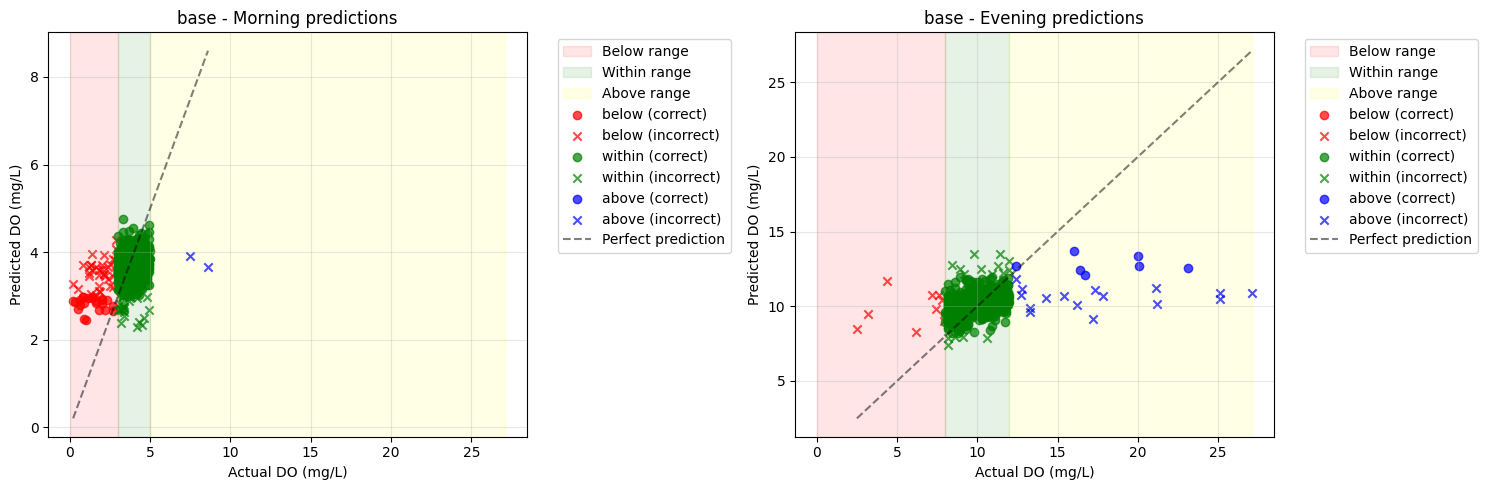


Analyzing base_w_categoricals feature set...

Below range DO (n=67)
RMSE: 2.260 | R²: -0.591
Precision: 0.370 | Recall: 0.254

Within range DO (n=1,325)
RMSE: 0.839 | R²: 0.932
Precision: 0.949 | Recall: 0.971

Above range DO (n=25)
RMSE: 7.644 | R²: -1.424
Precision: 0.400 | Recall: 0.240


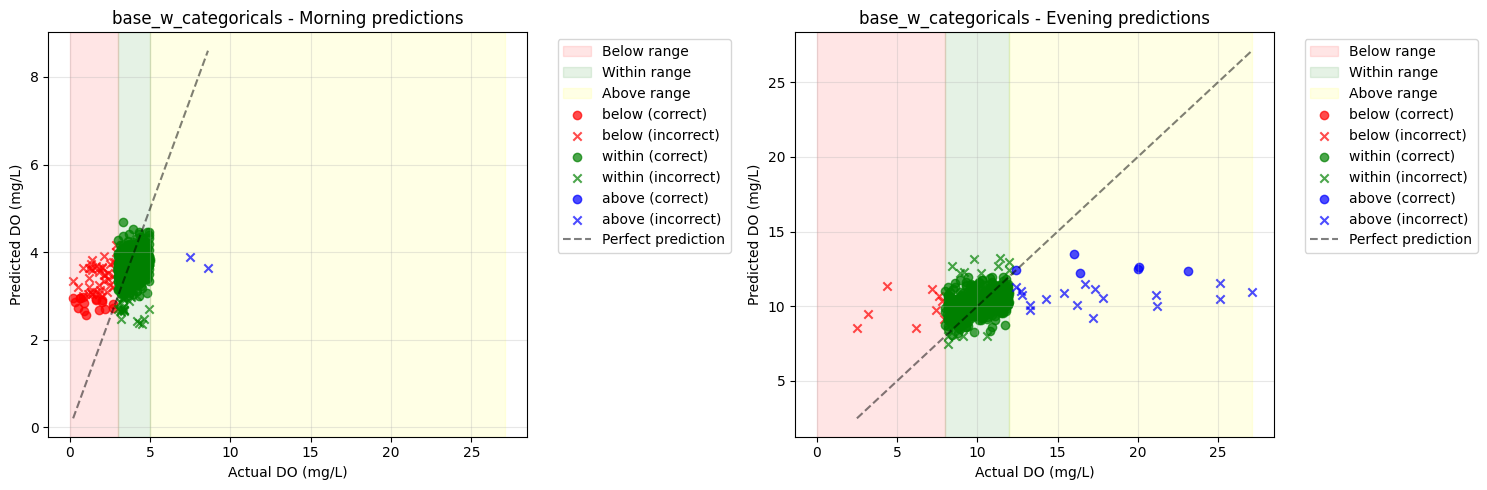


Analyzing base_lag feature set...

Below range DO (n=67)
RMSE: 2.240 | R²: -0.564
Precision: 0.404 | Recall: 0.284

Within range DO (n=1,325)
RMSE: 0.843 | R²: 0.932
Precision: 0.951 | Recall: 0.968

Above range DO (n=25)
RMSE: 7.511 | R²: -1.340
Precision: 0.318 | Recall: 0.280


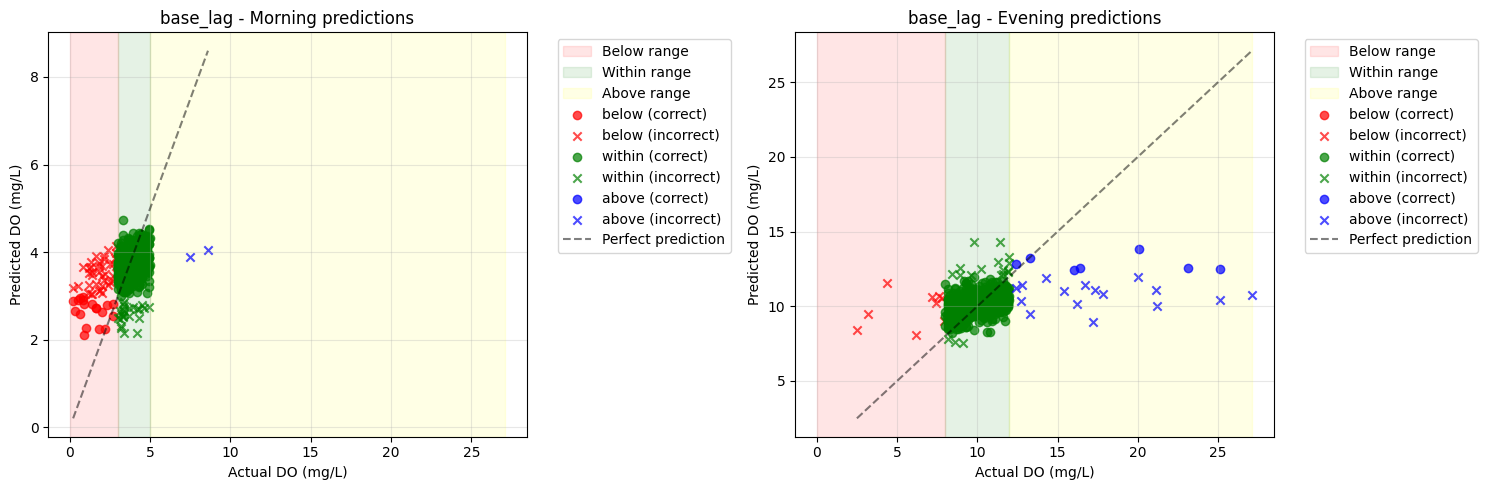


Analyzing base_satellite feature set...

Below range DO (n=67)
RMSE: 2.250 | R²: -0.577
Precision: 0.380 | Recall: 0.284

Within range DO (n=1,325)
RMSE: 0.840 | R²: 0.932
Precision: 0.950 | Recall: 0.971

Above range DO (n=25)
RMSE: 7.674 | R²: -1.443
Precision: 0.429 | Recall: 0.240


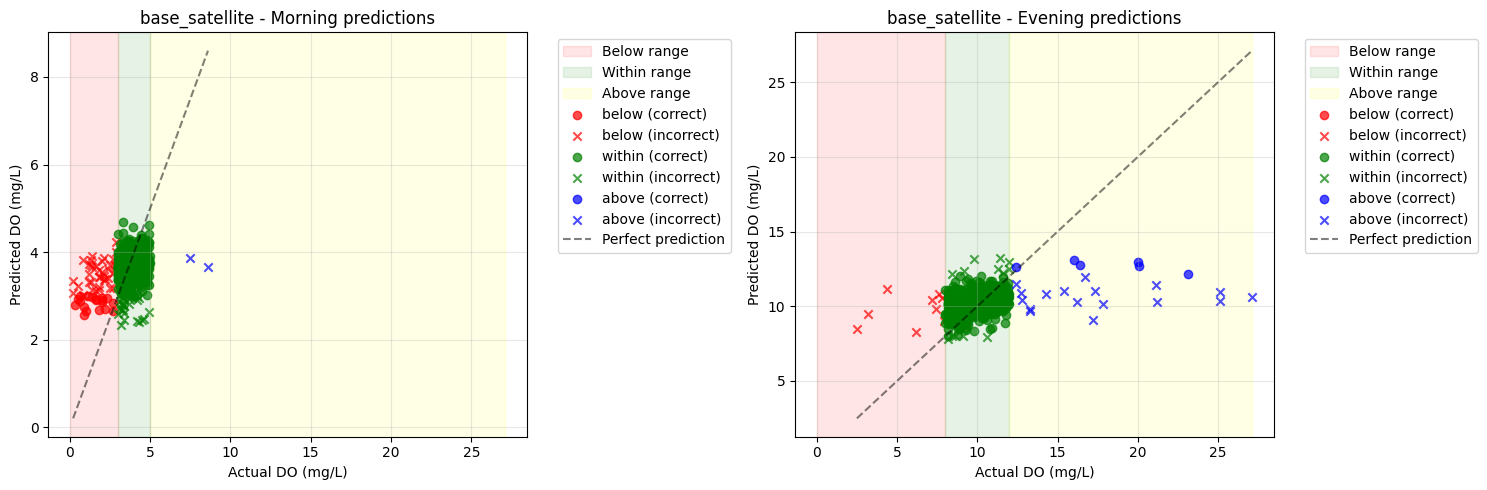


Analyzing base_pond feature set...

Below range DO (n=67)
RMSE: 2.199 | R²: -0.507
Precision: 0.458 | Recall: 0.328

Within range DO (n=1,325)
RMSE: 0.860 | R²: 0.929
Precision: 0.953 | Recall: 0.968

Above range DO (n=25)
RMSE: 7.525 | R²: -1.349
Precision: 0.292 | Recall: 0.280


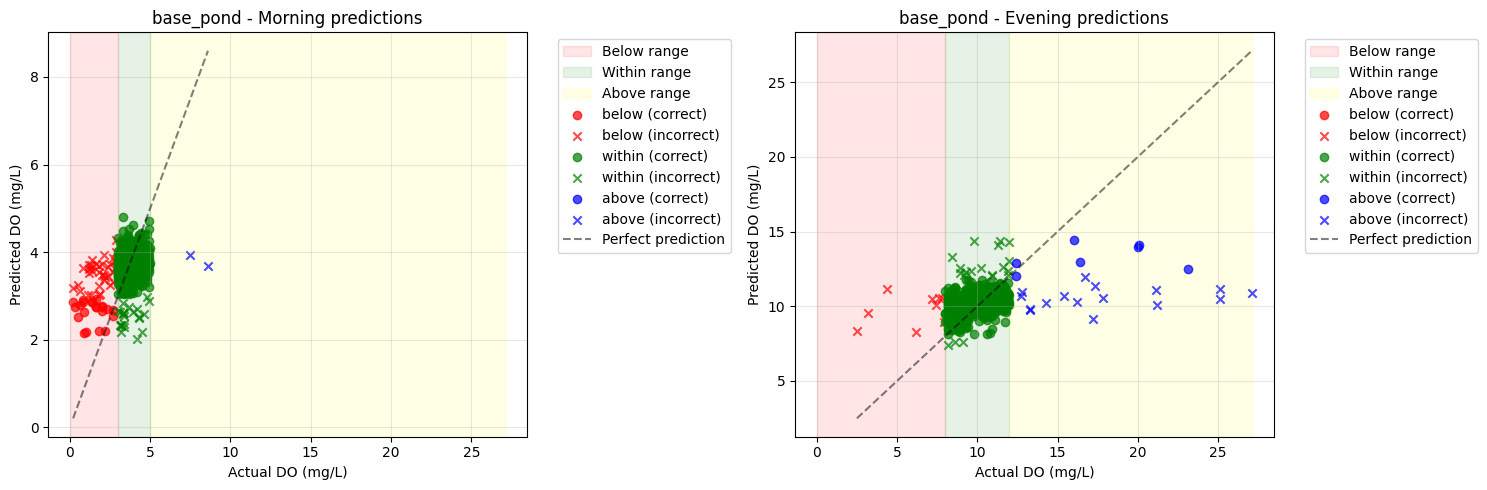


Analyzing high_corr_set feature set...

Below range DO (n=67)
RMSE: 2.299 | R²: -0.646
Precision: 0.290 | Recall: 0.134

Within range DO (n=1,325)
RMSE: 0.854 | R²: 0.930
Precision: 0.944 | Recall: 0.972

Above range DO (n=25)
RMSE: 7.491 | R²: -1.327
Precision: 0.286 | Recall: 0.240


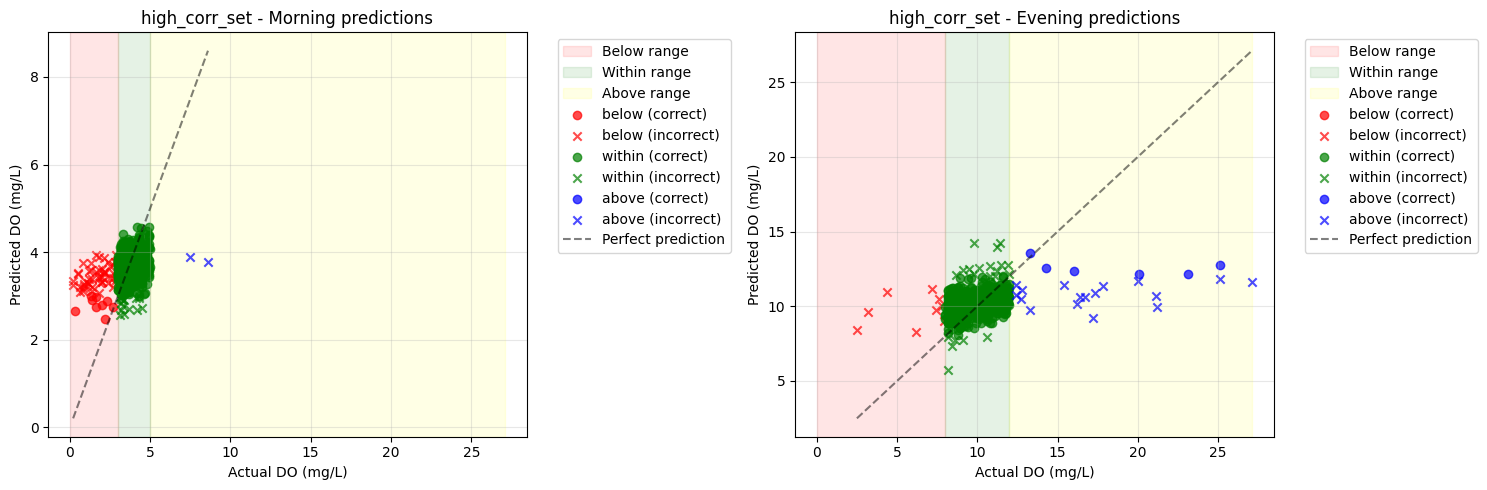

In [159]:
# Iterate through each feature set's results
for name, result in results.items():
    print(f"\nAnalyzing {name} feature set...")
    
    # Get predictions and actual values
    y_test = result['results']['y_true'] 
    y_pred = result['results']['y_pred']
    time_of_day = winkler_df['morning'].apply(lambda x: 'morning' if x else 'evening') # Hacky

    actual_range = get_in_required_range('do_mg_per_L', y_test, time_of_day)
    predicted_range = get_in_required_range('do_mg_per_L', y_pred, time_of_day)

    # Calculate metrics for each range category
    categories = ['below', 'within', 'above']
    for category in categories:
        actual_mask = actual_range == category
        pred_mask = predicted_range == category
        
        if actual_mask.any():
            category_rmse = root_mean_squared_error(y_test[actual_mask], y_pred[actual_mask])
            category_r2 = r2_score(y_test[actual_mask], y_pred[actual_mask])
            precision = precision_score(actual_range == category, predicted_range == category)
            recall = recall_score(actual_range == category, predicted_range == category)
            
            print(f"\n{category.capitalize()} range DO (n={actual_mask.sum():,})")
            print(f"RMSE: {category_rmse:.3f} | R²: {category_r2:.3f}")
            print(f"Precision: {precision:.3f} | Recall: {recall:.3f}")

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    colors = {'above': 'blue', 'within': 'green', 'below': 'red'}
    do_ranges = WQ_RANGES['do_mg_per_L']['required']

    for i, tod in enumerate(['morning', 'evening']):
        plt.subplot(1, 2, i+1)
        tod_mask = time_of_day == tod
        
        # Show prediction regions
        plt.axvspan(0, do_ranges[tod][0], alpha=0.1, color='red', label='Below range')
        plt.axvspan(do_ranges[tod][0], do_ranges[tod][1], alpha=0.1, color='green', label='Within range')
        plt.axvspan(do_ranges[tod][1], max(y_test.max(), y_pred.max()), 
                   alpha=0.1, color='yellow', label='Above range')
        
        # Plot points by category
        for category in categories:
            category_mask = tod_mask & (actual_range == category)
            correct_mask = category_mask & (actual_range == predicted_range)
            incorrect_mask = category_mask & (actual_range != predicted_range)
            
            plt.scatter(y_test[correct_mask], y_pred[correct_mask],
                       alpha=0.7, c=colors[category], marker='o',
                       label=f'{category} (correct)')
            plt.scatter(y_test[incorrect_mask], y_pred[incorrect_mask],
                       alpha=0.7, c=colors[category], marker='x',
                       label=f'{category} (incorrect)')

        # Add diagonal line
        plt.plot([y_test[tod_mask].min(), y_test[tod_mask].max()],
                 [y_test[tod_mask].min(), y_test[tod_mask].max()],
                 'k--', alpha=0.5, label='Perfect prediction')
        
        plt.xlabel('Actual DO (mg/L)')
        plt.ylabel('Predicted DO (mg/L)')
        plt.title(f'{name} - {tod.capitalize()} predictions')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


### With feature selection


Running experiment with base features...


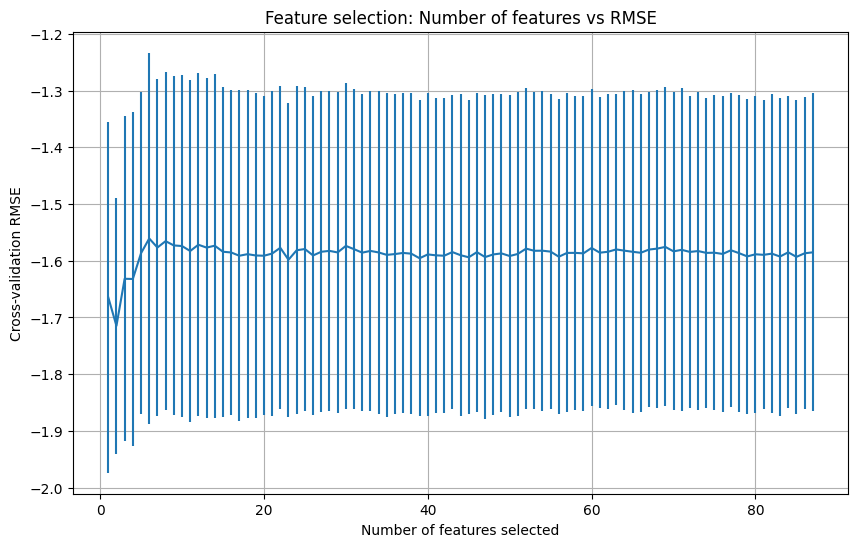

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


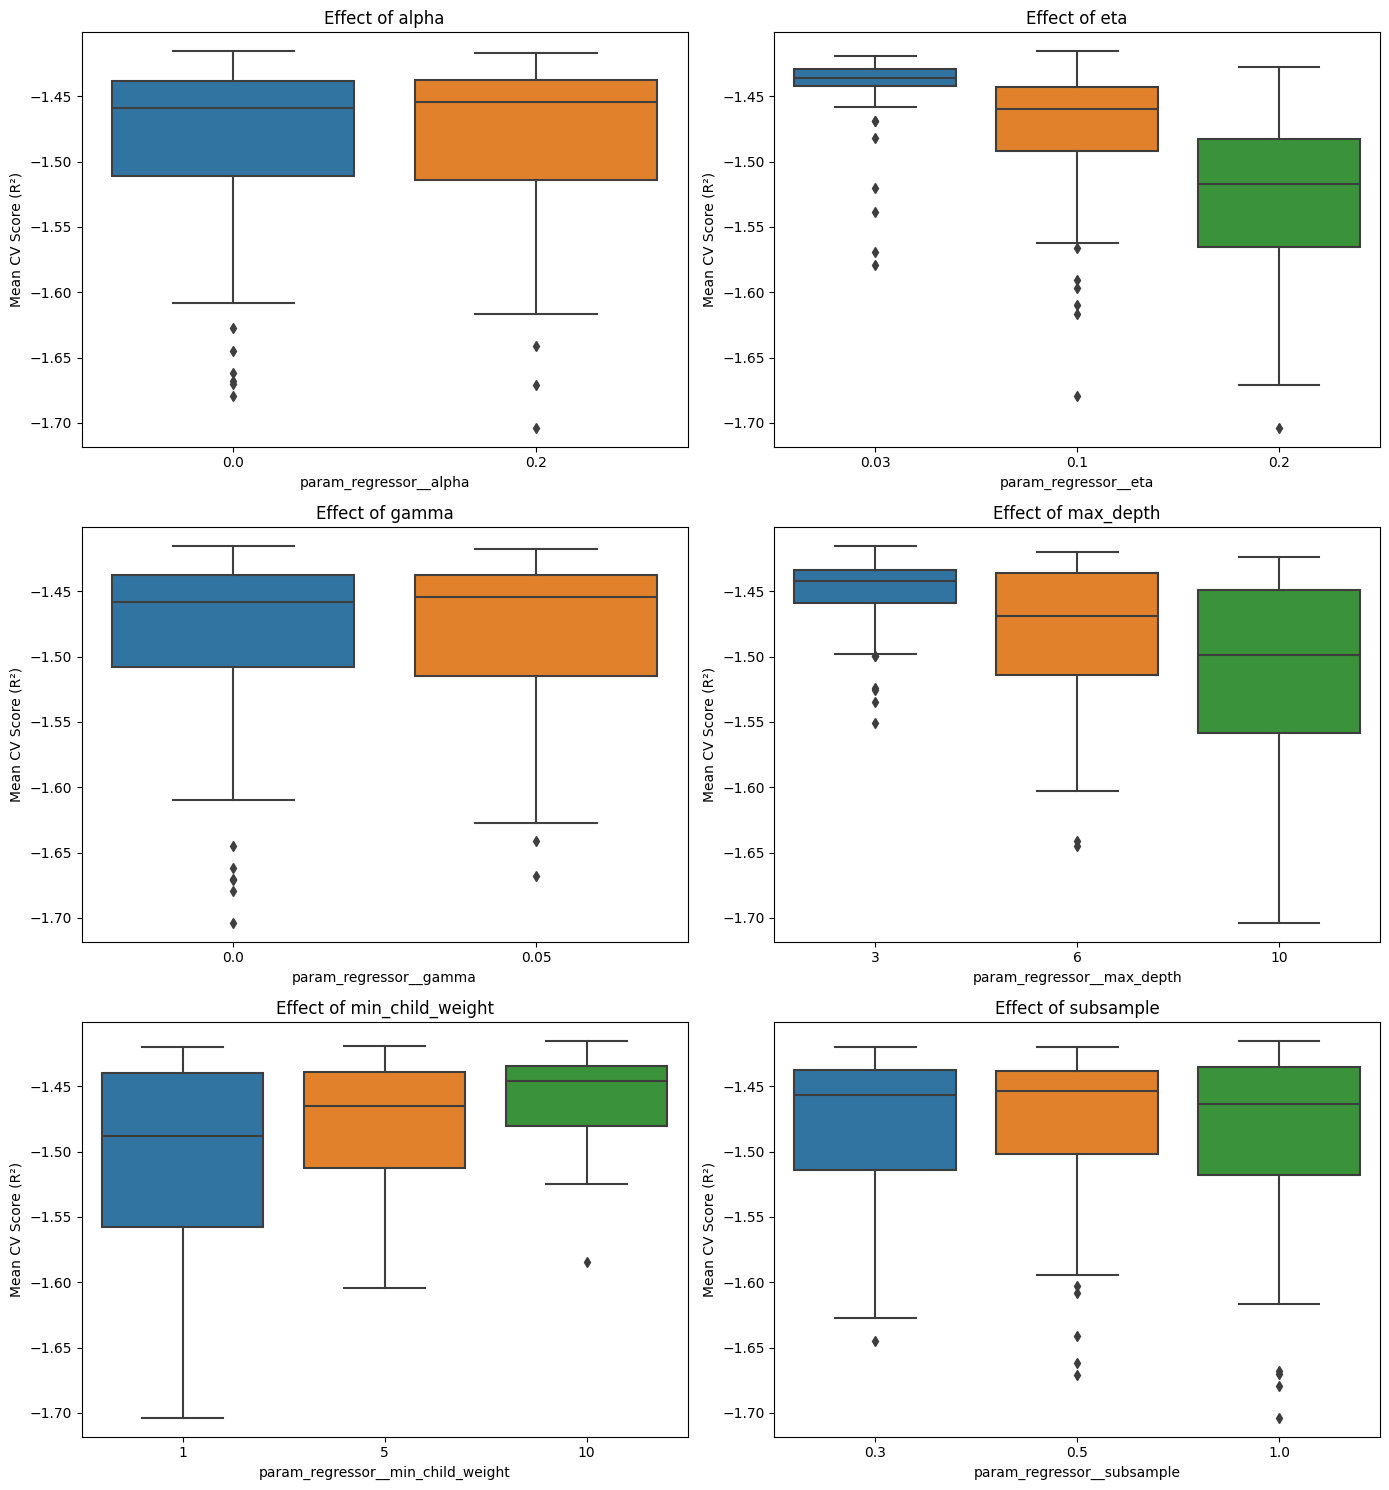

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

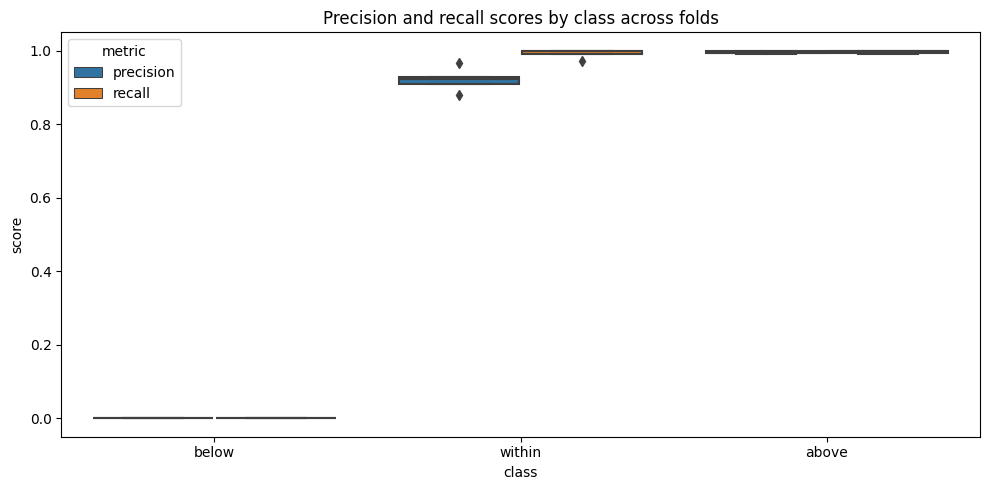

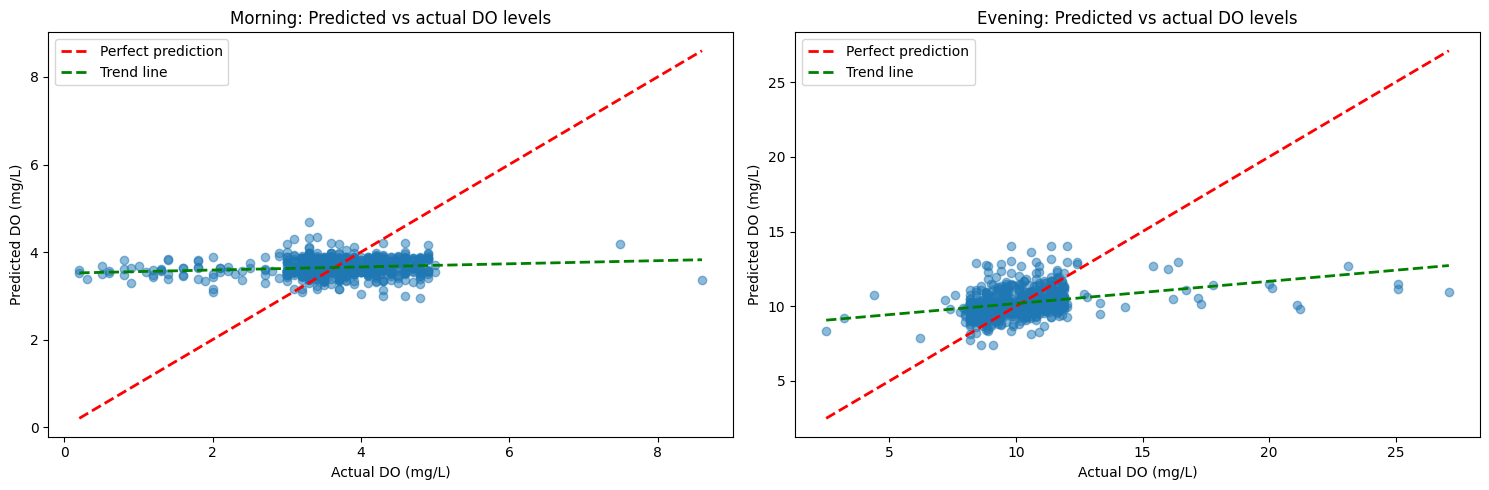

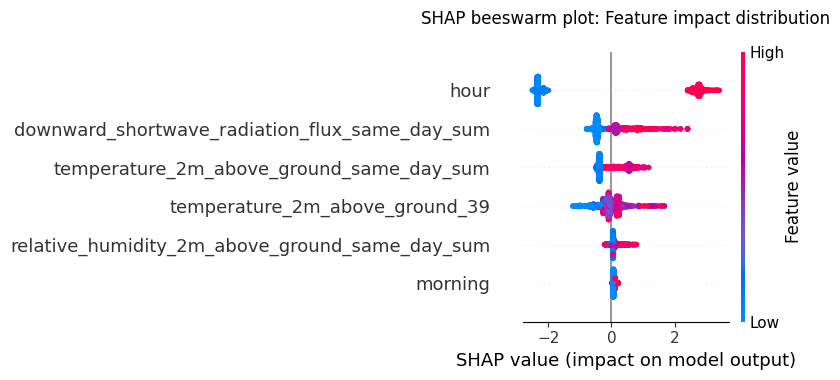

Best score: -1.416
Range prediction accuracy: 0.920

Running experiment with all_features features...


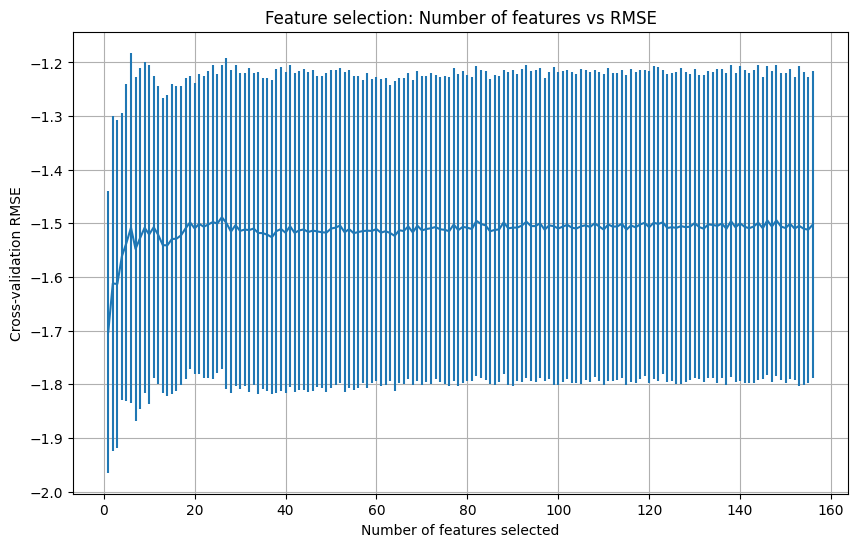

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


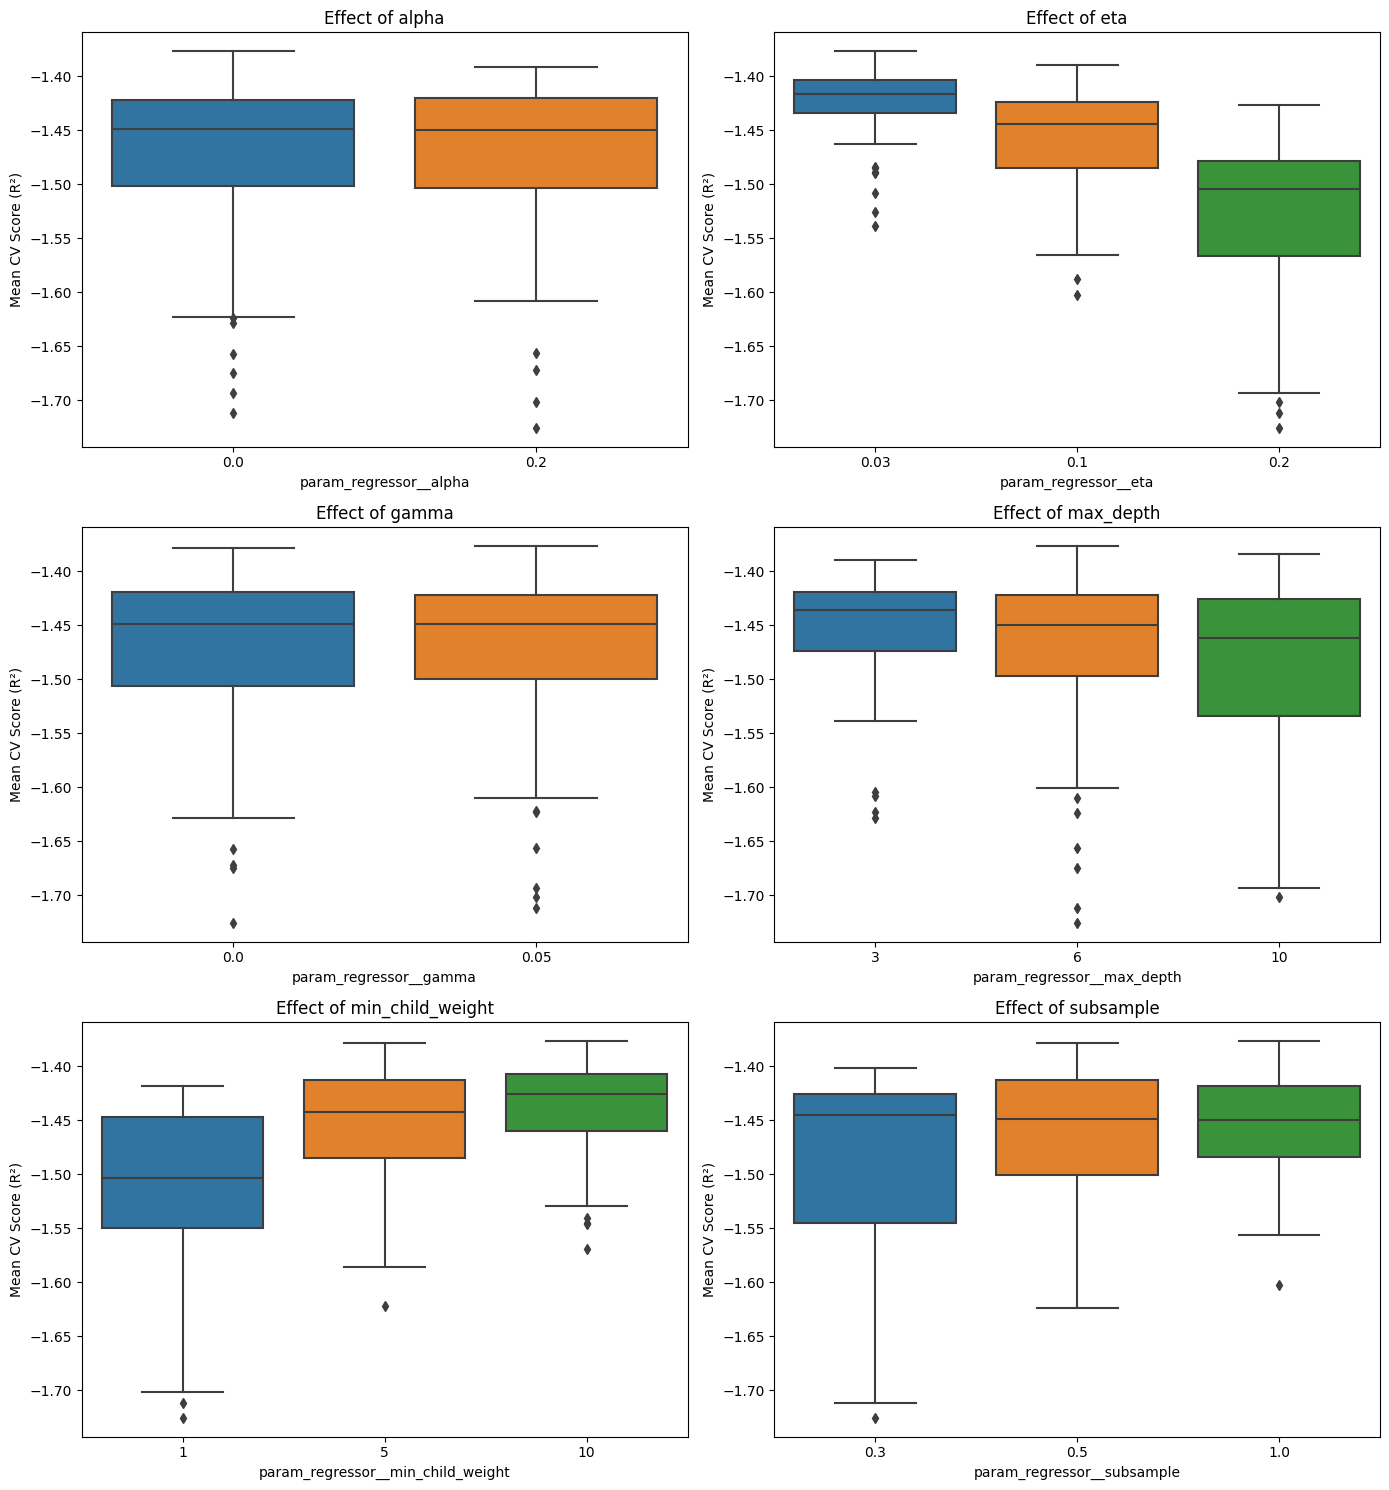

c:\Users\squaade\Documents\Github\fwi-predict\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


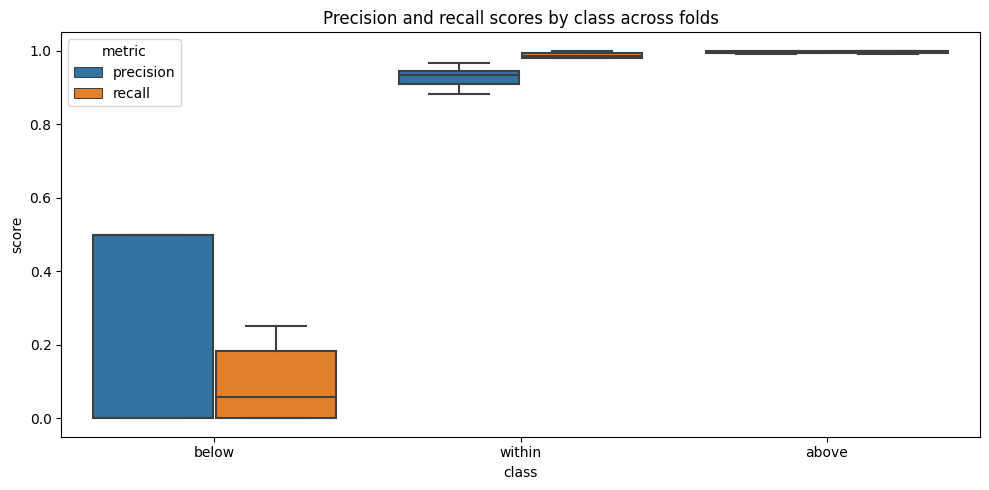

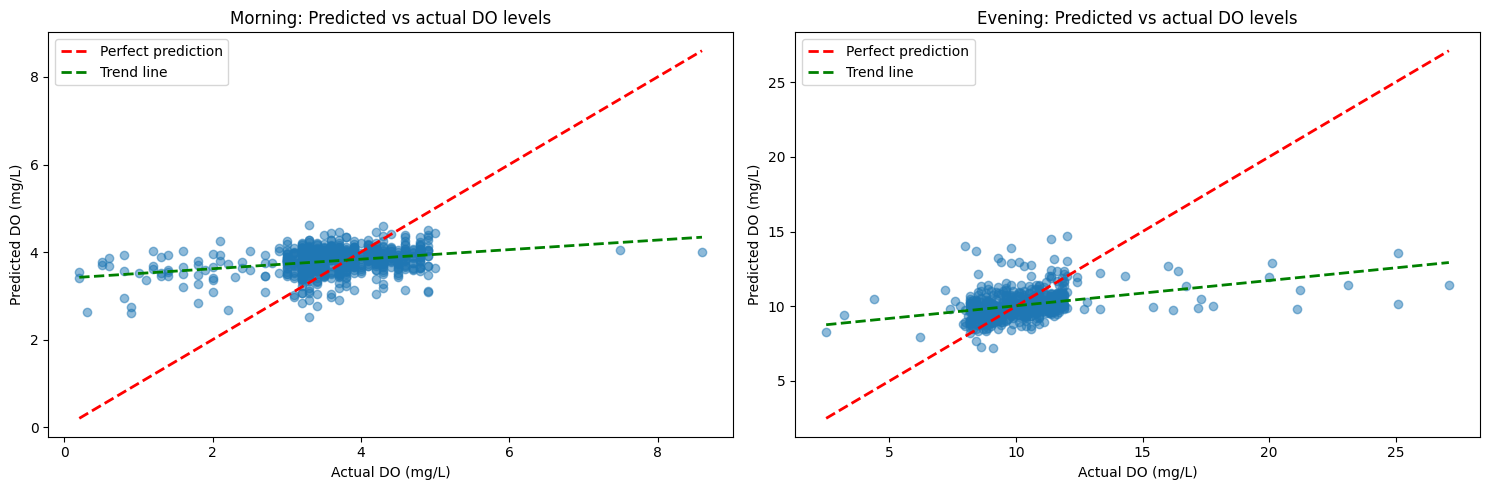

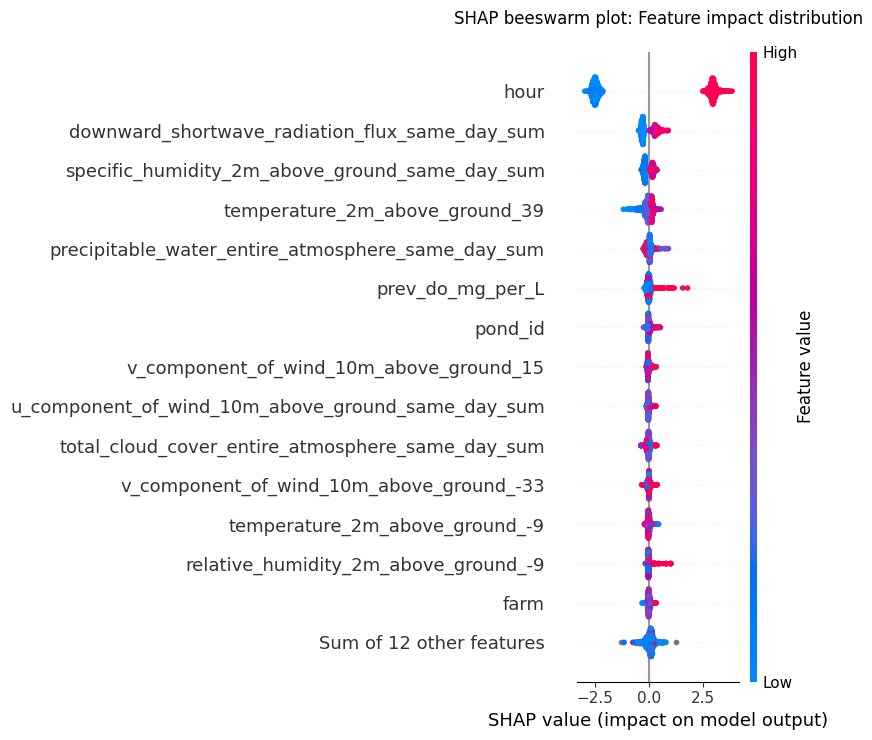

Best score: -1.377
Range prediction accuracy: 0.923

Running experiment with all_without_lag features...


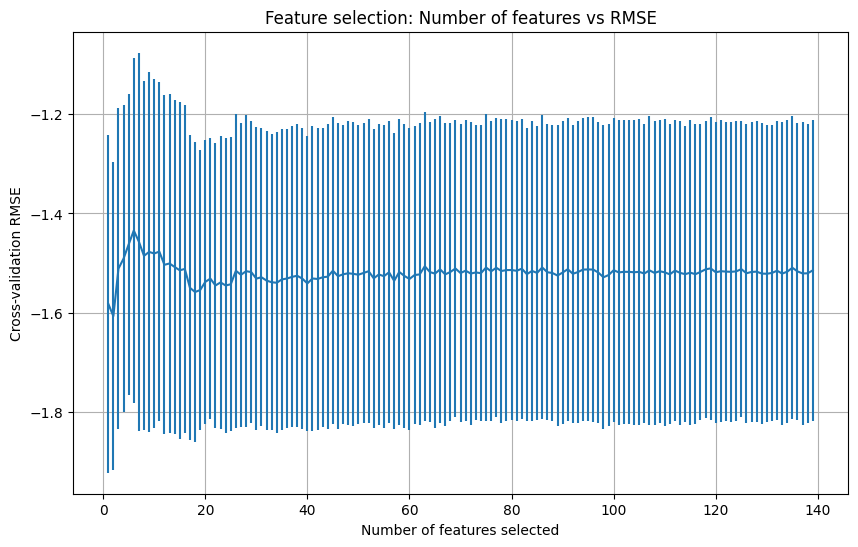

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


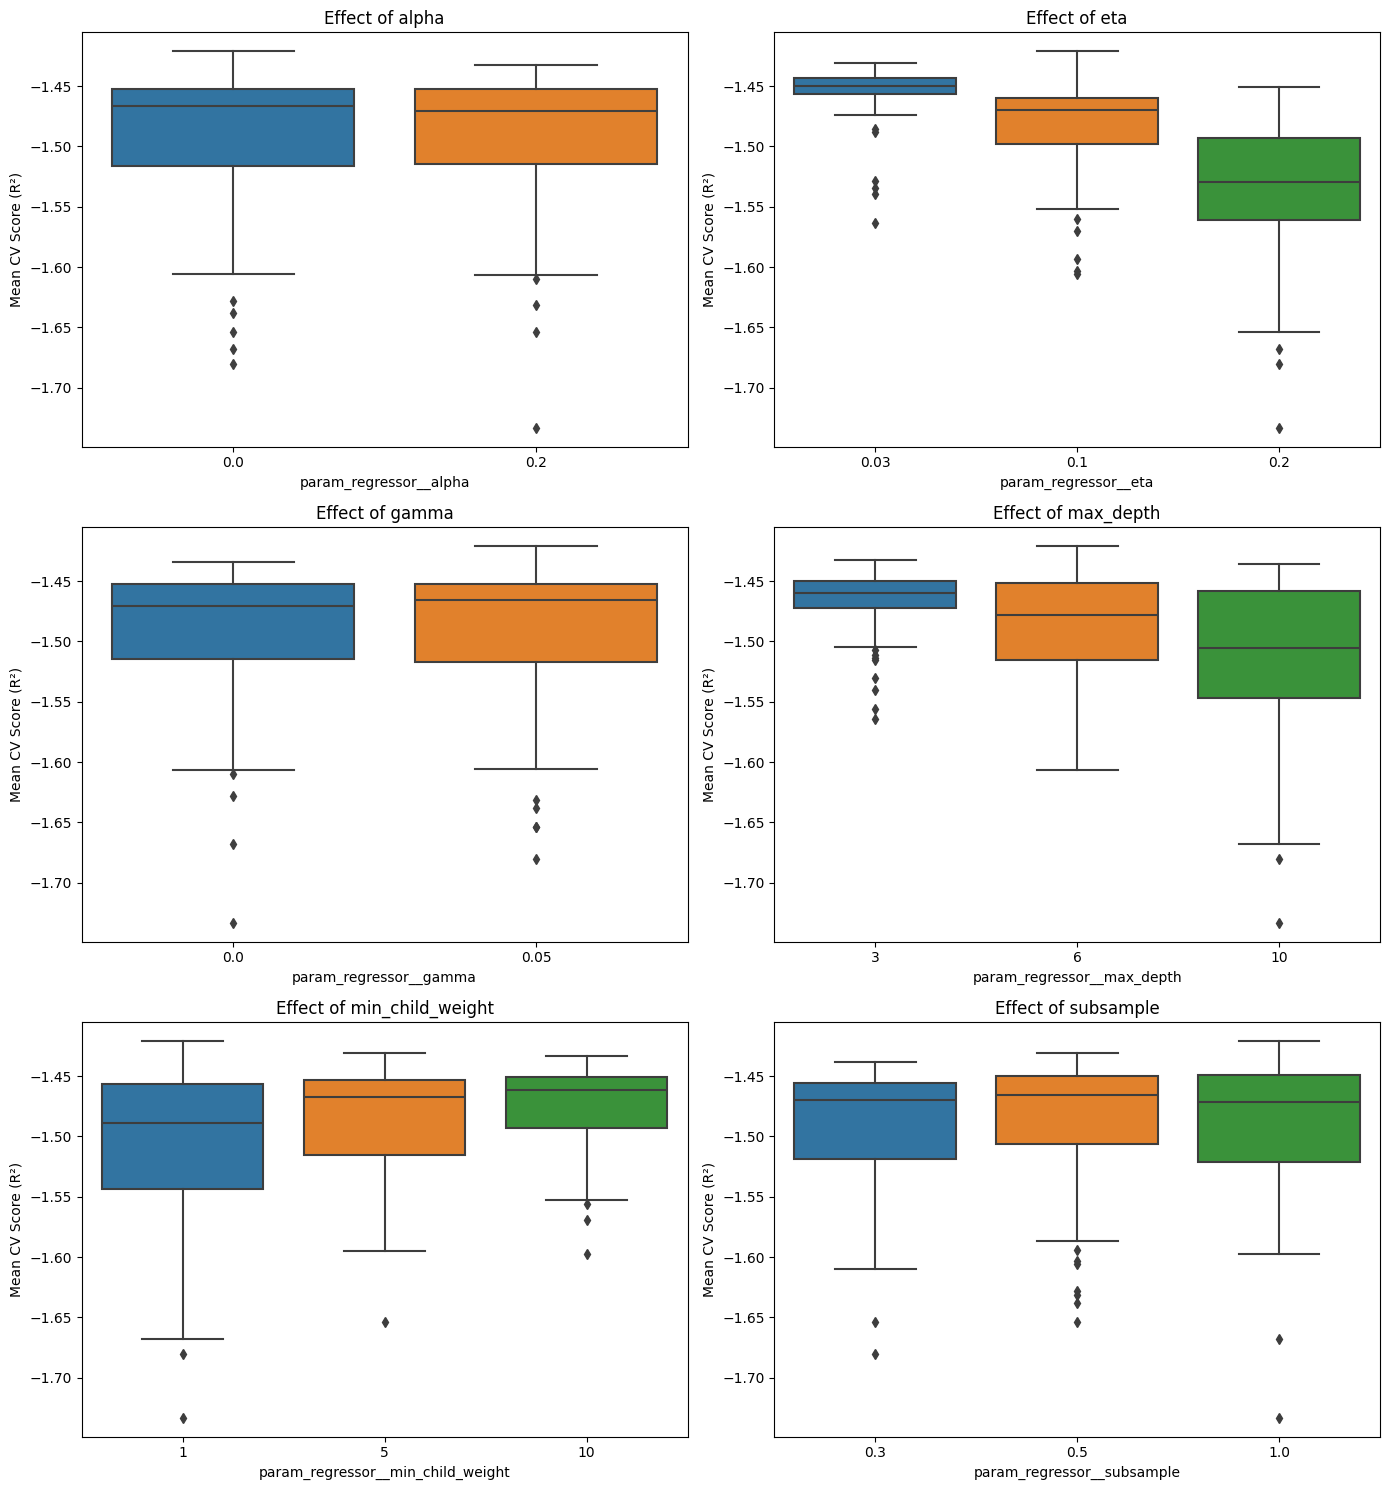

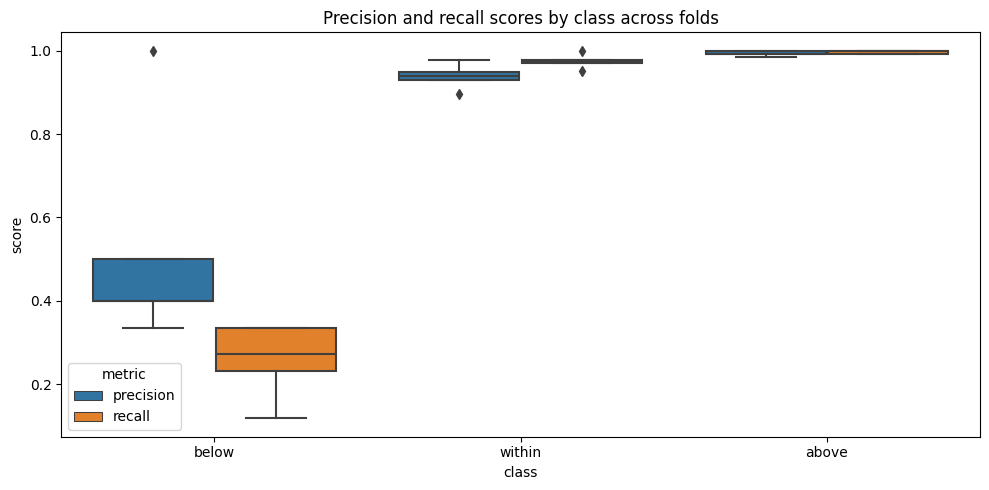

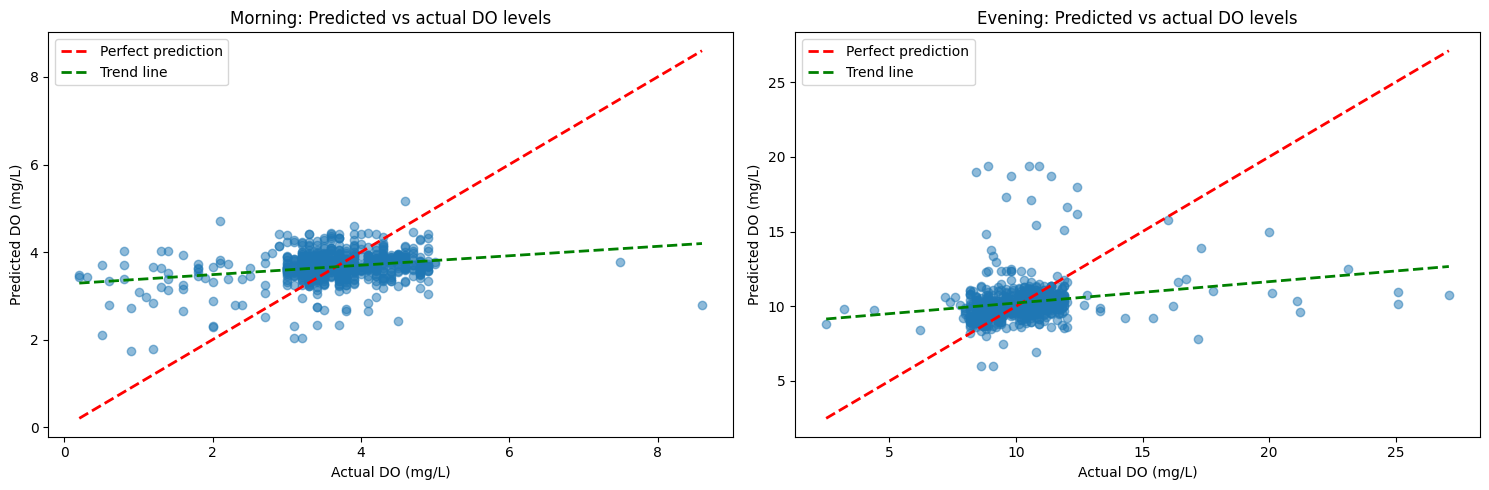

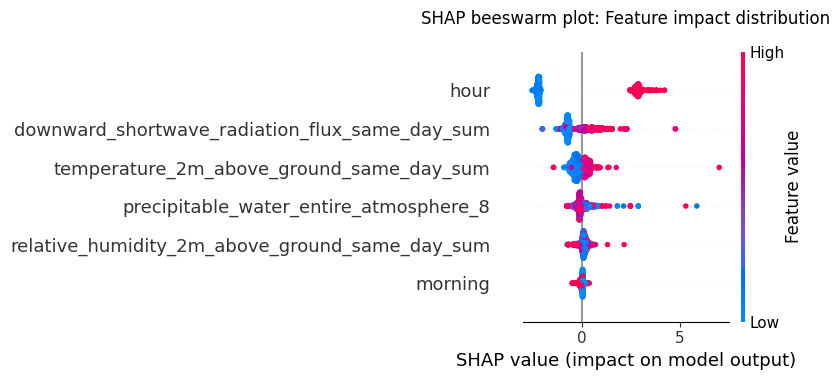

Best score: -1.421
Range prediction accuracy: 0.917


In [19]:
# Run experiments with different feature sets
all_features = experiment_df.columns[experiment_df.columns != 'do_mg_per_L'].tolist()
all_features = [feature for feature in all_features if feature not in satellite_features]
feature_sets = {
    'base': base_feature_set,
    'all_features': all_features,
    'all_without_lag': [feature for feature in all_features if feature not in lag_features]
}

fs_results = {}
for name, features in feature_sets.items():
    print(f"\nRunning experiment with {name} features...")
    fs_results[name] = run_experiment(experiment_df, features, categoricals, feature_selection=True, diurnal_detrend=False)
    print(f"Best score: {fs_results[name]['best_score']:.3f}")
    print(f"Range prediction accuracy: {fs_results[name]['results']['range_accuracy']:.3f}")

In [20]:
import json

In [21]:
outdir = Path("../../models/do_mg_per_L")
outdir.mkdir(parents=True, exist_ok=True)

for name, result_dict in fs_results.items():
		
		model = result_dict['best_estimator']
		feature_names = result_dict['feature_names'].tolist()

		with open(outdir / f'{name}.pkl', 'wb') as f:
				pickle.dump(model, f)

		with open(outdir / f'{name}_features.json', 'w') as f:
				json.dump(feature_names, f)

In [22]:
# Run experiments with different feature sets
all_features = experiment_df.columns[experiment_df.columns != 'do_mg_per_L'].tolist()
all_features_no_lag = [name for name in all_features if name not in lag_features]
feature_sets = {
    'base': base_feature_set,
    'all_features': all_features,
    'all_features_no_log': all_features_no_lag
}

results = {}
for name, features in feature_sets.items():
    print(f"\nRunning experiment with {name} features...")
    results[name] = run_experiment(experiment_df,
                                   features,
                                   categoricals,
                                   diurnal_detrend=False,
                                   feature_selection=True)
    print(f"Best score: {results[name]['best_score']:.3f}")
    print(f"Range prediction accuracy: {results[name]['results']['range_accuracy']:.3f}")



Running experiment with base features...


KeyboardInterrupt: 


Analyzing base feature set...

Below range DO (n=67)
RMSE: 2.400 | R²: -0.794
Precision: 0.143 | Recall: 0.015

Within range DO (n=1,325)
RMSE: 0.902 | R²: 0.922
Precision: 0.938 | Recall: 0.978

Above range DO (n=25)
RMSE: 7.681 | R²: -1.447
Precision: 0.207 | Recall: 0.240


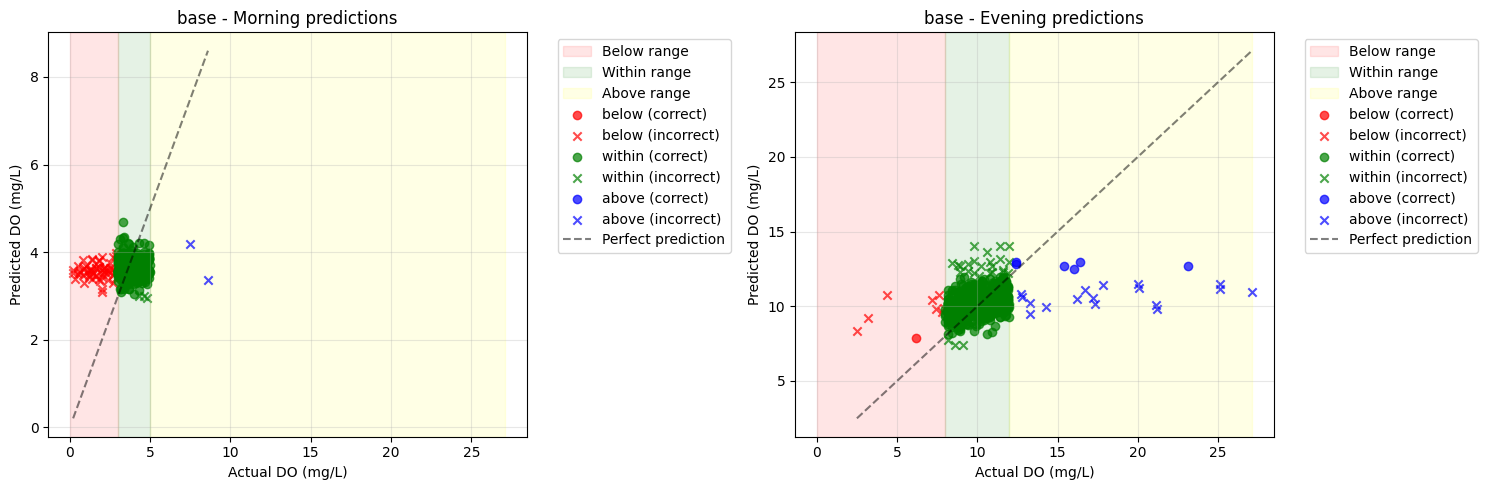


Analyzing all_features feature set...

Below range DO (n=67)
RMSE: 2.395 | R²: -0.788
Precision: 0.412 | Recall: 0.104

Within range DO (n=1,325)
RMSE: 0.860 | R²: 0.929
Precision: 0.943 | Recall: 0.977

Above range DO (n=25)
RMSE: 7.581 | R²: -1.384
Precision: 0.231 | Recall: 0.240


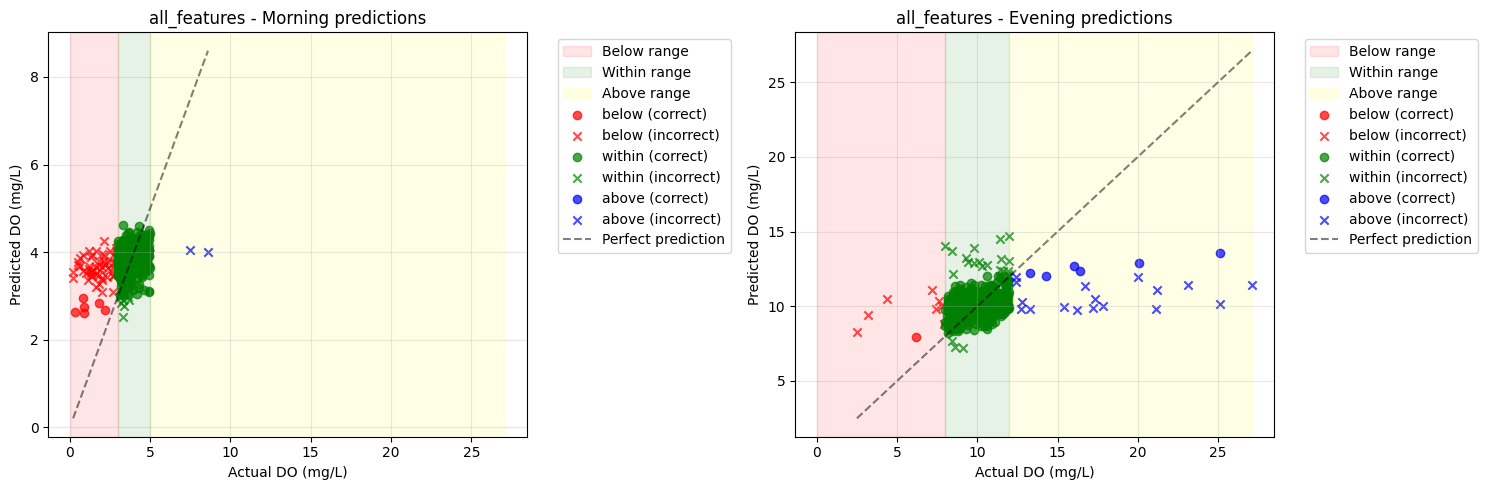


Analyzing all_without_lag feature set...

Below range DO (n=67)
RMSE: 2.303 | R²: -0.653
Precision: 0.389 | Recall: 0.209

Within range DO (n=1,325)
RMSE: 1.154 | R²: 0.872
Precision: 0.948 | Recall: 0.965

Above range DO (n=25)
RMSE: 7.967 | R²: -1.633
Precision: 0.188 | Recall: 0.240


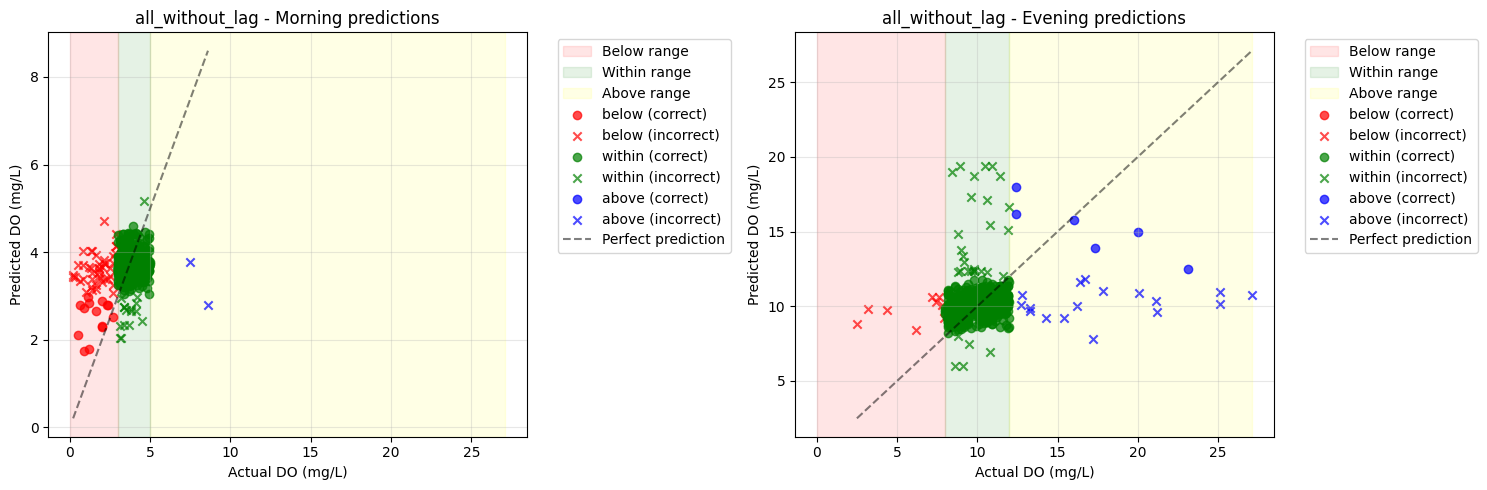

In [25]:
# Iterate through each feature set's results
for name, result in fs_results.items():
    print(f"\nAnalyzing {name} feature set...")
    
    # Get predictions and actual values
    y_test = result['results']['y_true'] 
    y_pred = result['results']['y_pred']
    time_of_day = experiment_df['morning'].apply(lambda x: 'morning' if x else 'evening') # Hacky

    actual_range = get_in_required_range('do_mg_per_L', y_test, time_of_day)
    predicted_range = get_in_required_range('do_mg_per_L', y_pred, time_of_day)

    # Calculate metrics for each range category
    categories = ['below', 'within', 'above']
    for category in categories:
        actual_mask = actual_range == category
        pred_mask = predicted_range == category
        
        if actual_mask.any():
            category_rmse = root_mean_squared_error(y_test[actual_mask], y_pred[actual_mask])
            category_r2 = r2_score(y_test[actual_mask], y_pred[actual_mask])
            precision = precision_score(actual_range == category, predicted_range == category)
            recall = recall_score(actual_range == category, predicted_range == category)
            
            print(f"\n{category.capitalize()} range DO (n={actual_mask.sum():,})")
            print(f"RMSE: {category_rmse:.3f} | R²: {category_r2:.3f}")
            print(f"Precision: {precision:.3f} | Recall: {recall:.3f}")

    # Visualize predictions
    plt.figure(figsize=(15, 5))
    colors = {'above': 'blue', 'within': 'green', 'below': 'red'}
    do_ranges = WQ_RANGES['do_mg_per_L']['required']

    for i, tod in enumerate(['morning', 'evening']):
        plt.subplot(1, 2, i+1)
        tod_mask = time_of_day == tod
        
        # Show prediction regions
        plt.axvspan(0, do_ranges[tod][0], alpha=0.1, color='red', label='Below range')
        plt.axvspan(do_ranges[tod][0], do_ranges[tod][1], alpha=0.1, color='green', label='Within range')
        plt.axvspan(do_ranges[tod][1], max(y_test.max(), y_pred.max()), 
                   alpha=0.1, color='yellow', label='Above range')
        
        # Plot points by category
        for category in categories:
            category_mask = tod_mask & (actual_range == category)
            correct_mask = category_mask & (actual_range == predicted_range)
            incorrect_mask = category_mask & (actual_range != predicted_range)
            
            plt.scatter(y_test[correct_mask], y_pred[correct_mask],
                       alpha=0.7, c=colors[category], marker='o',
                       label=f'{category} (correct)')
            plt.scatter(y_test[incorrect_mask], y_pred[incorrect_mask],
                       alpha=0.7, c=colors[category], marker='x',
                       label=f'{category} (incorrect)')

        # Add diagonal line
        plt.plot([y_test[tod_mask].min(), y_test[tod_mask].max()],
                 [y_test[tod_mask].min(), y_test[tod_mask].max()],
                 'k--', alpha=0.5, label='Perfect prediction')
        
        plt.xlabel('Actual DO (mg/L)')
        plt.ylabel('Predicted DO (mg/L)')
        plt.title(f'{name} - {tod.capitalize()} predictions')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


### Do the by pond predictions

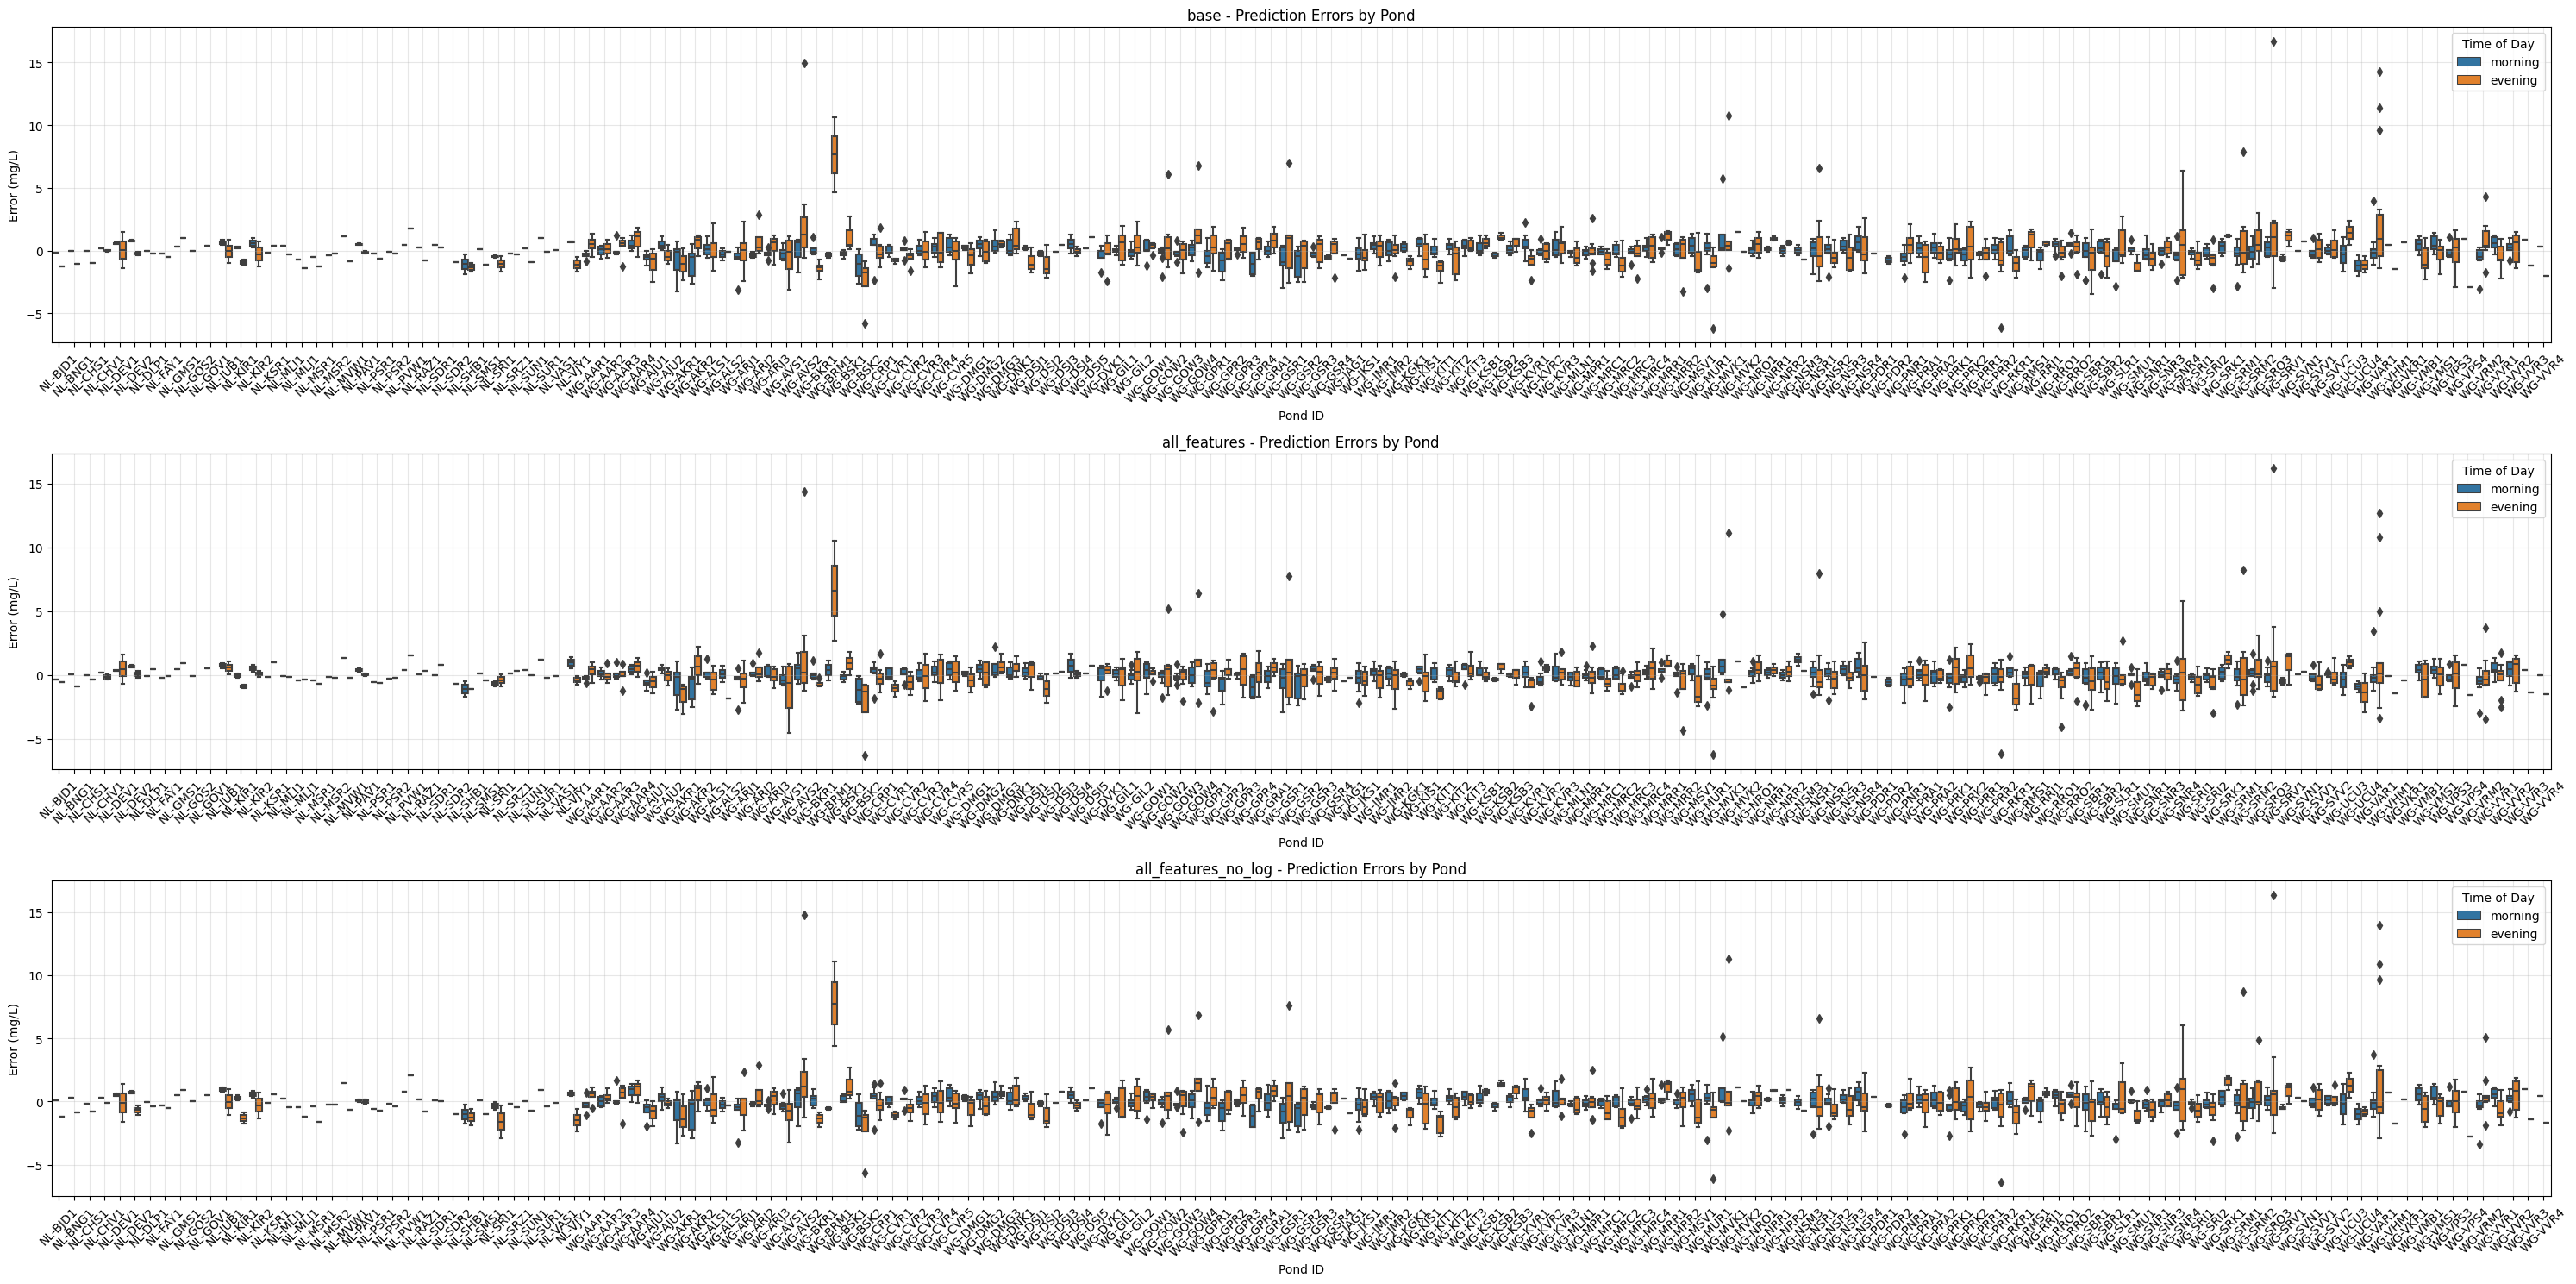

In [31]:
# Get number of models for subplot layout
n_models = len(results)
n_rows = n_models
n_cols = 1

# Create figure for boxplots
plt.figure(figsize=(30, 5*n_rows))

for model_idx, (exp_name, result) in enumerate(results.items()):
    # Get data for this model
    y_test = result['results']['y_true']
    y_pred = result['results']['y_pred']
    time_of_day = experiment_df['morning'].apply(lambda x: 'morning' if x else 'evening')
    
    errors = pd.DataFrame({
        'pond_id': experiment_df['pond_id'],
        'error': y_test - y_pred,
        'time_of_day': time_of_day
    })
    
    # Single subplot with hue for time of day
    plt.subplot(n_rows, n_cols, model_idx + 1)
    sns.boxplot(data=errors, x='pond_id', y='error', hue='time_of_day')
    plt.xticks(rotation=45)
    plt.xlabel('Pond ID')
    plt.ylabel('Error (mg/L)')
    plt.title(f'{exp_name} - Prediction Errors by Pond')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Time of Day')

plt.tight_layout()
plt.show()


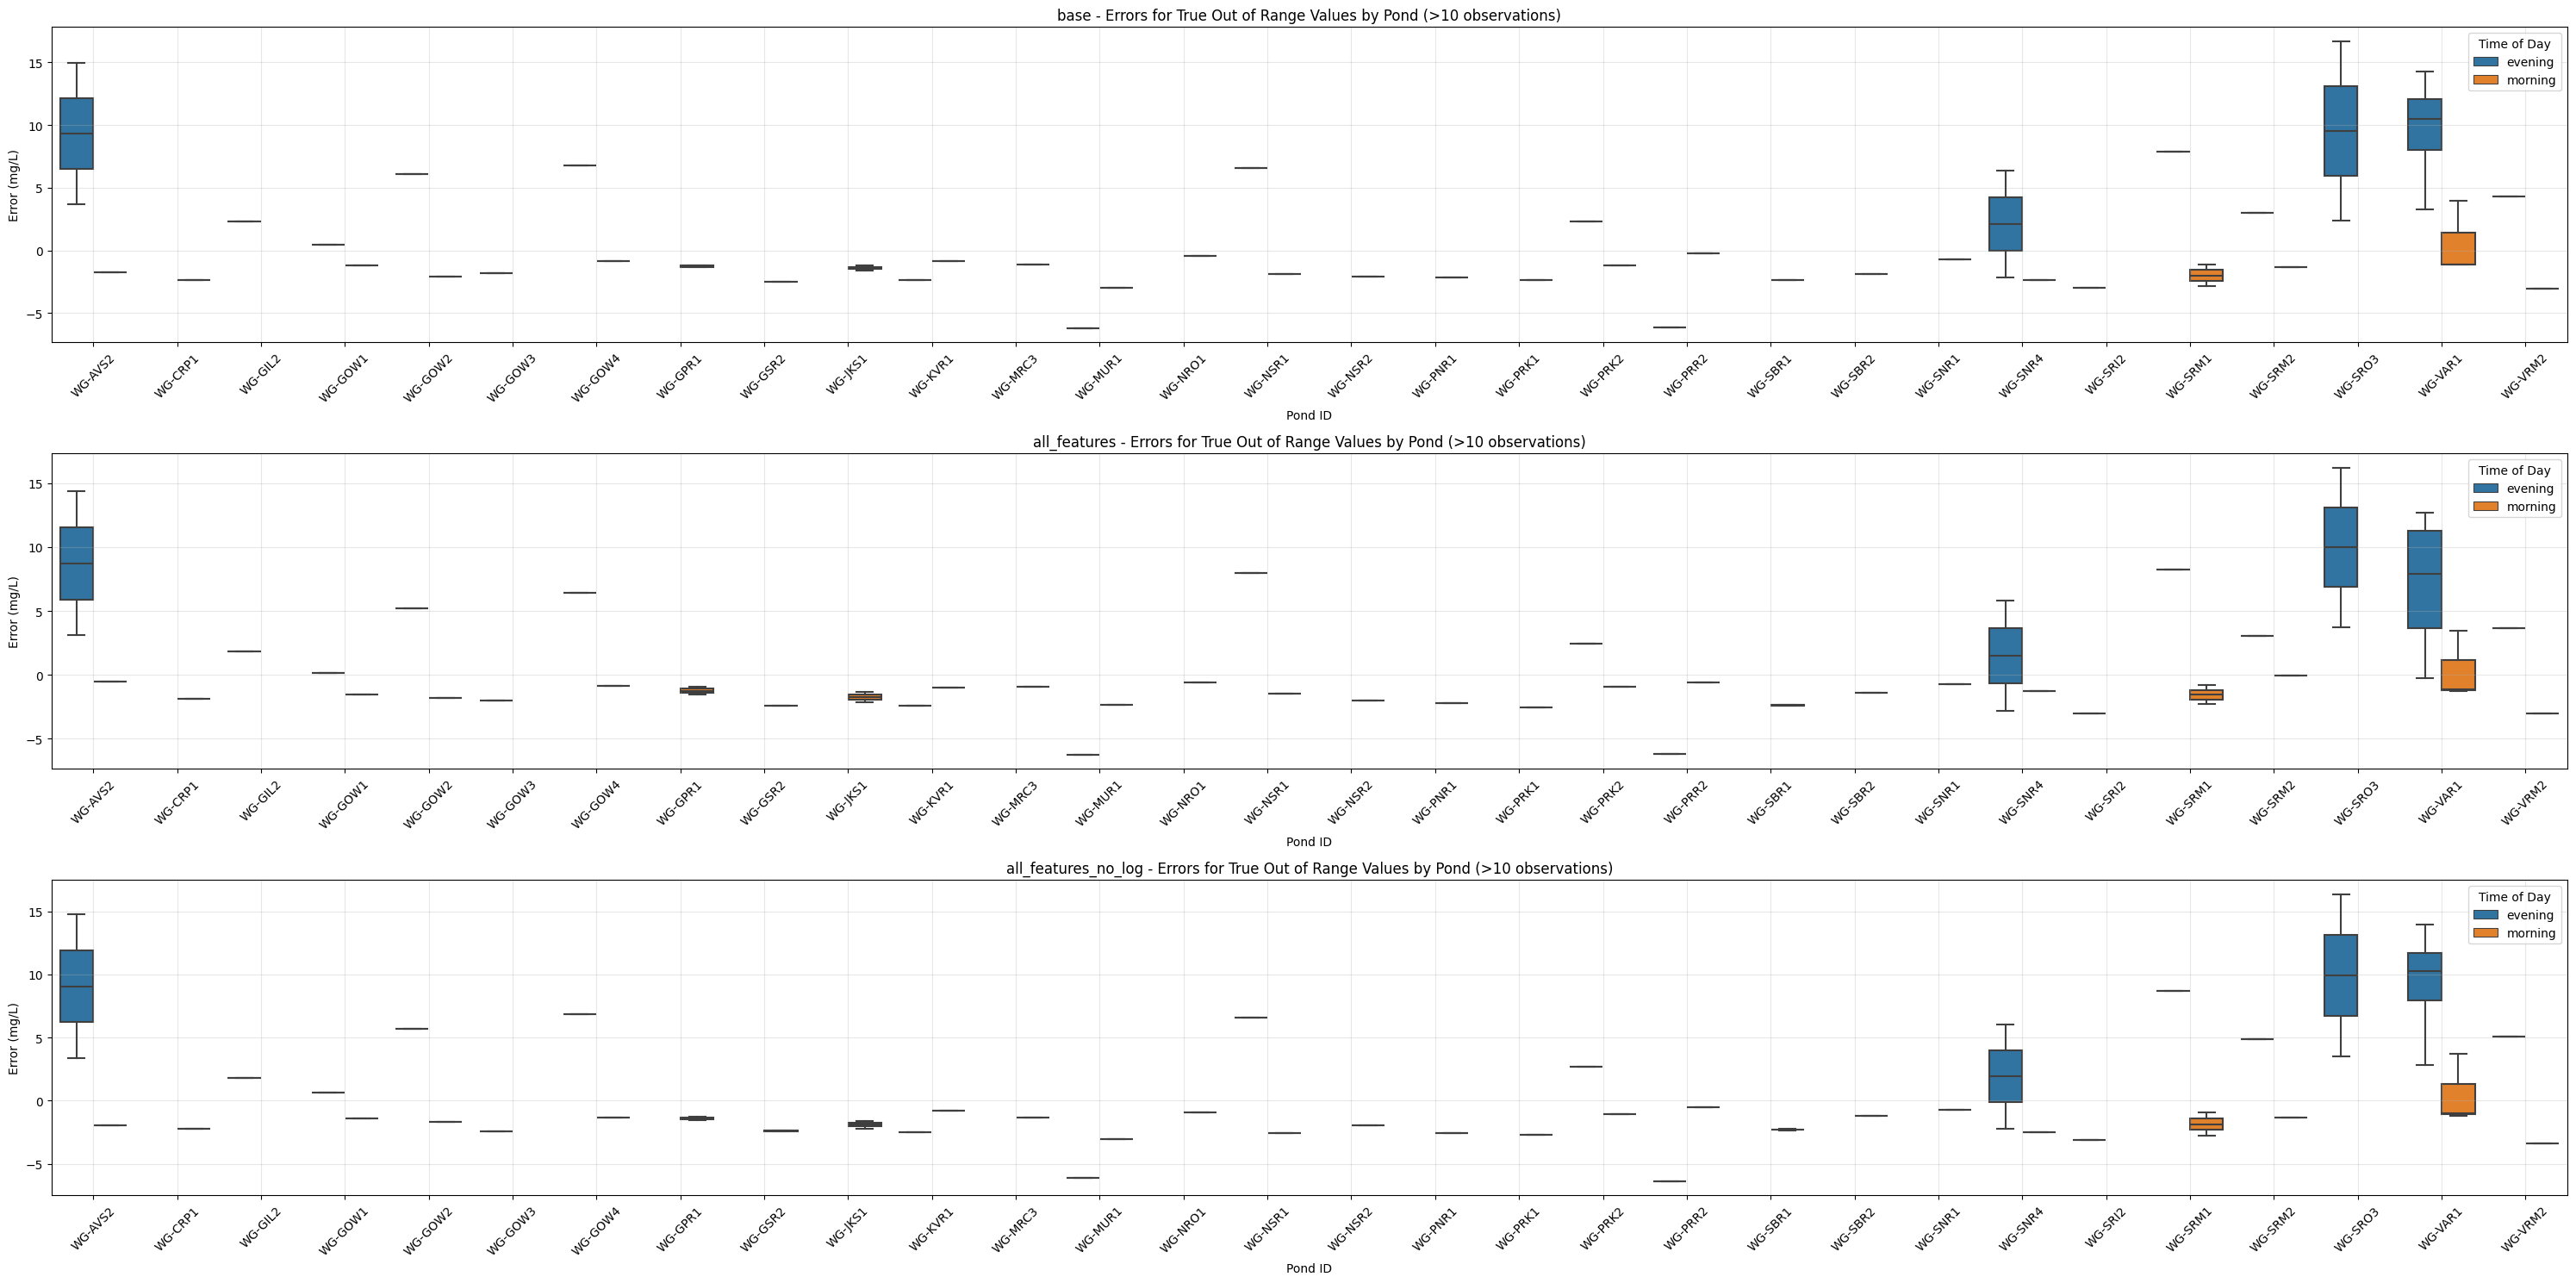

In [40]:
# Get number of models for subplot layout
n_models = len(results)
n_rows = n_models
n_cols = 1

# Create figure for boxplots
plt.figure(figsize=(30, 5*n_rows))

for model_idx, (exp_name, result) in enumerate(results.items()):
    # Get data for this model
    y_true = result['results']['y_true']
    y_pred = result['results']['y_pred']
    time_of_day = experiment_df['morning'].apply(lambda x: 'morning' if x else 'evening')
    
    true_range_status = get_in_required_range(
        parameter='do_mg_per_L',
        values=y_true,
        periods=time_of_day
    )
    
    
    # Calculate errors and identify out of range predictions using wq utility
    errors = pd.DataFrame({
        'pond_id': experiment_df['pond_id'],
        'error': y_true - y_pred,
        'time_of_day': time_of_day,
        'range_status': true_range_status,
        'y_pred': y_pred,
        'y_true': y_true
    })
    
    # Filter for ponds with more than 3 observations
    pond_counts = errors['pond_id'].value_counts()
    ponds_to_keep = pond_counts[pond_counts > 10].index
    
    # Then filter for out of range values
    errors_out_of_range = errors[
        (errors['range_status'] != 'within') & 
        (errors['pond_id'].isin(ponds_to_keep))
    ]
    errors_filtered = errors_out_of_range
    
    # Single subplot with hue for time of day
    plt.subplot(n_rows, n_cols, model_idx + 1)
    sns.boxplot(data=errors_filtered, x='pond_id', y='error', hue='time_of_day')
    plt.xticks(rotation=45)
    plt.xlabel('Pond ID')
    plt.ylabel('Error (mg/L)')
    plt.title(f'{exp_name} - Errors for True Out of Range Values by Pond (>10 observations)')
    plt.grid(True, alpha=0.3)
    plt.legend(title='Time of Day')

plt.tight_layout()
plt.show()


#### Output models for daily prediction